# Assignment 3 - Unsupervised Learning

In [860]:
import itertools
import os
import pickle
import warnings
from collections import Counter, defaultdict
from datetime import datetime
from itertools import product
from pathlib import Path
from pprint import pprint
from time import time

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
from IPython import display
from matplotlib import cm
from scipy.linalg import pinv
from scipy.stats import describe, kurtosis
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import (confusion_matrix, make_scorer, silhouette_samples,
                             silhouette_score)
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (GridSearchCV, ShuffleSplit,
                                     learning_curve, train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.random_projection import SparseRandomProjection
from sklearn.random_projection import SparseRandomProjection as RCA
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.utils import compute_sample_weight
from sklearn.metrics import plot_roc_curve
from yellowbrick.model_selection import LearningCurve


from tqdm import tqdm
import seaborn as sns; sns.set()

Use some of the clustering and dimensionality reduction algorithms.
Goal: think about how these algorithms are the same as, different from, and interact with your earlier work.


Implement six algorithms. The first two are clustering algorithms:

1. k-means clustering
2. Expectation Maximization
You can choose your own measures of distance/similarity. Naturally, you'll have to justify your choices, but you're practiced at that sort of thing by now.

The last four algorithms are dimensionality reduction algorithms:

1. PCA (include eigenvalues)
2. ICA (kurtosis) 
3. Randomized Projections (reconstruction error) 
4. Any other feature selection algorithm you desire (whatever you want) 
Run a number of experiments on two datasets.


1. Run the **clustering** algorithms on the datasets and describe what you see. (metrics for density+seperablity/visuals), (compare soft & hard clustering)
2. Apply the **dimensionality reduction** algorithms to the two datasets and describe what you see. (visualization/way to understand what the new projection looks like -tSNE/pairwise plot) 
3. **Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it.** Yes, that’s 16 combinations of datasets, dimensionality reduction, and clustering method. Look at all of them, but focus on the more interesting findings in your report.
4. Apply the dimensionality reduction algorithms to one of your datasets from assignment #1 (if you've reused the datasets from assignment #1 to do experiments 1-3 above then you've already done this) and rerun your neural network learner on the newly projected data.
5. Apply the clustering algorithms to the same dataset to which you just applied the dimensionality reduction algorithms (you've probably already done this), treating the clusters as if they were new features. In other words, treat the clustering algorithms as if they were dimensionality reduction algorithms. Again, rerun your neural network learner on the newly projected data.

* K-means: sklearn.cluster.KMeans
* EM: sklearn.mixture.GaussianMixture
* PCA: sklearn.decomposition.PCA
* ICA: sklearn.decomposition.FastICA
* Random Projection: sklearn.random_projection.GaussianRandomProjection
* LDA: sklearn.discriminant_analysis.LinearDiscriminantAnalysis

Include in your analysis: 

* a discussion of your datasets, and why they're interesting: 

* If you're using the same datasets as before at least briefly remind us of what they are so we don't have to revisit your old assignment write-up..

* explanations of your methods: for example, how did you choose k?
* a description of the kind of clusters that you got.
* analyses of your results. 
    1. Why did you get the clusters you did? Do they make "sense"? 
    2. If you used data that already had labels (for example data from a classification problem from assignment #1) did the clusters line up with the labels? 
    3. Do they otherwise line up naturally? Why or why not? Compare and contrast the different algorithms. 
    4. What sort of changes might you make to each of those algorithms to improve performance? 
    5. How much performance was due to the problems you chose? Be creative and think of as many questions you can, and as many answers as you can. Take care to justify your analysis with data explicitly.  
    
* Can you describe how the data look in the new spaces you created with the various algorithms? 
1. For PCA, what is the distribution of eigenvalues? 
2. For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? 
3. How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?

* When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA, and RP, did you get the same clusters as before? Different clusters? Why? Why not?
* When you re-ran your neural network algorithms were there any differences in performance? Speed? Anything at all?
It might be difficult to generate the same kinds of graphs for this part of the assignment as you did before; however, you should come up with some way to describe the kinds of clusters you get. If you can do that visually all the better. 

**Types of Clustering**

Broadly speaking, clustering can be divided into two subgroups :

Hard Clustering: In hard clustering, each data point either belongs to a cluster completely or not. For example, in the above example each customer is put into one group out of the 10 groups.
Soft Clustering: In soft clustering, instead of putting each data point into a separate cluster, a probability or likelihood of that data point to be in those clusters is assigned. For example, from the above scenario each costumer is assigned a probability to be in either of 10 clusters of the retail store.


[**Reconstruction Error Code**](https://github.com/siddharth691/Unsupervised-Learning/blob/master/dim_reduce_cluster_rp_sensor.py)

## Dataset 1

In [1232]:
X = pd.read_pickle('https://github.com/otevet/unsupervised_learning/X1.pkl')
X.head(2)

age  education.num  sex  capital.loss  hours.per.week  \
1   82              9    0          4356              18   
3   54              4    0          3900              40   

   workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
1                      0                    0                  1   
3                      0                    0                  1   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  ...  \
1                       0                           0  ...   
3                       0                           0  ...   

   native.country_Portugal  native.country_Puerto-Rico  \
1                        0                           0   
3                        0                           0   

   native.country_Scotland  native.country_South  native.country_Taiwan  \
1                        0                     0                      0   
3                        0                     0                      0   

   native.country_Thailand  native.country_Trinadad&Tobago  \
1                        0                               0   
3                        0                               0   

   native.country_United-States  native.country_Vietnam  \
1                             1                       0   
3                             1                       0   

   native.country_Yugoslavia  
1                          0  
3                          0  

[2 rows x 95 columns]

In [1233]:
y = pd.read_pickle('https://github.com/otevet/unsupervised_learning/y1.pkl')
y.head(2)

1    0
3    0
Name: income, dtype: int8

In [1234]:
features = list(X.columns.values)

scaler = MinMaxScaler(feature_range=[0,100])
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [1235]:
ds_name = 'income'

In [1236]:
X.columns=features

NMI score: 0.169571
For n_clusters = 2 The average silhouette_score is : 0.12238996177185793


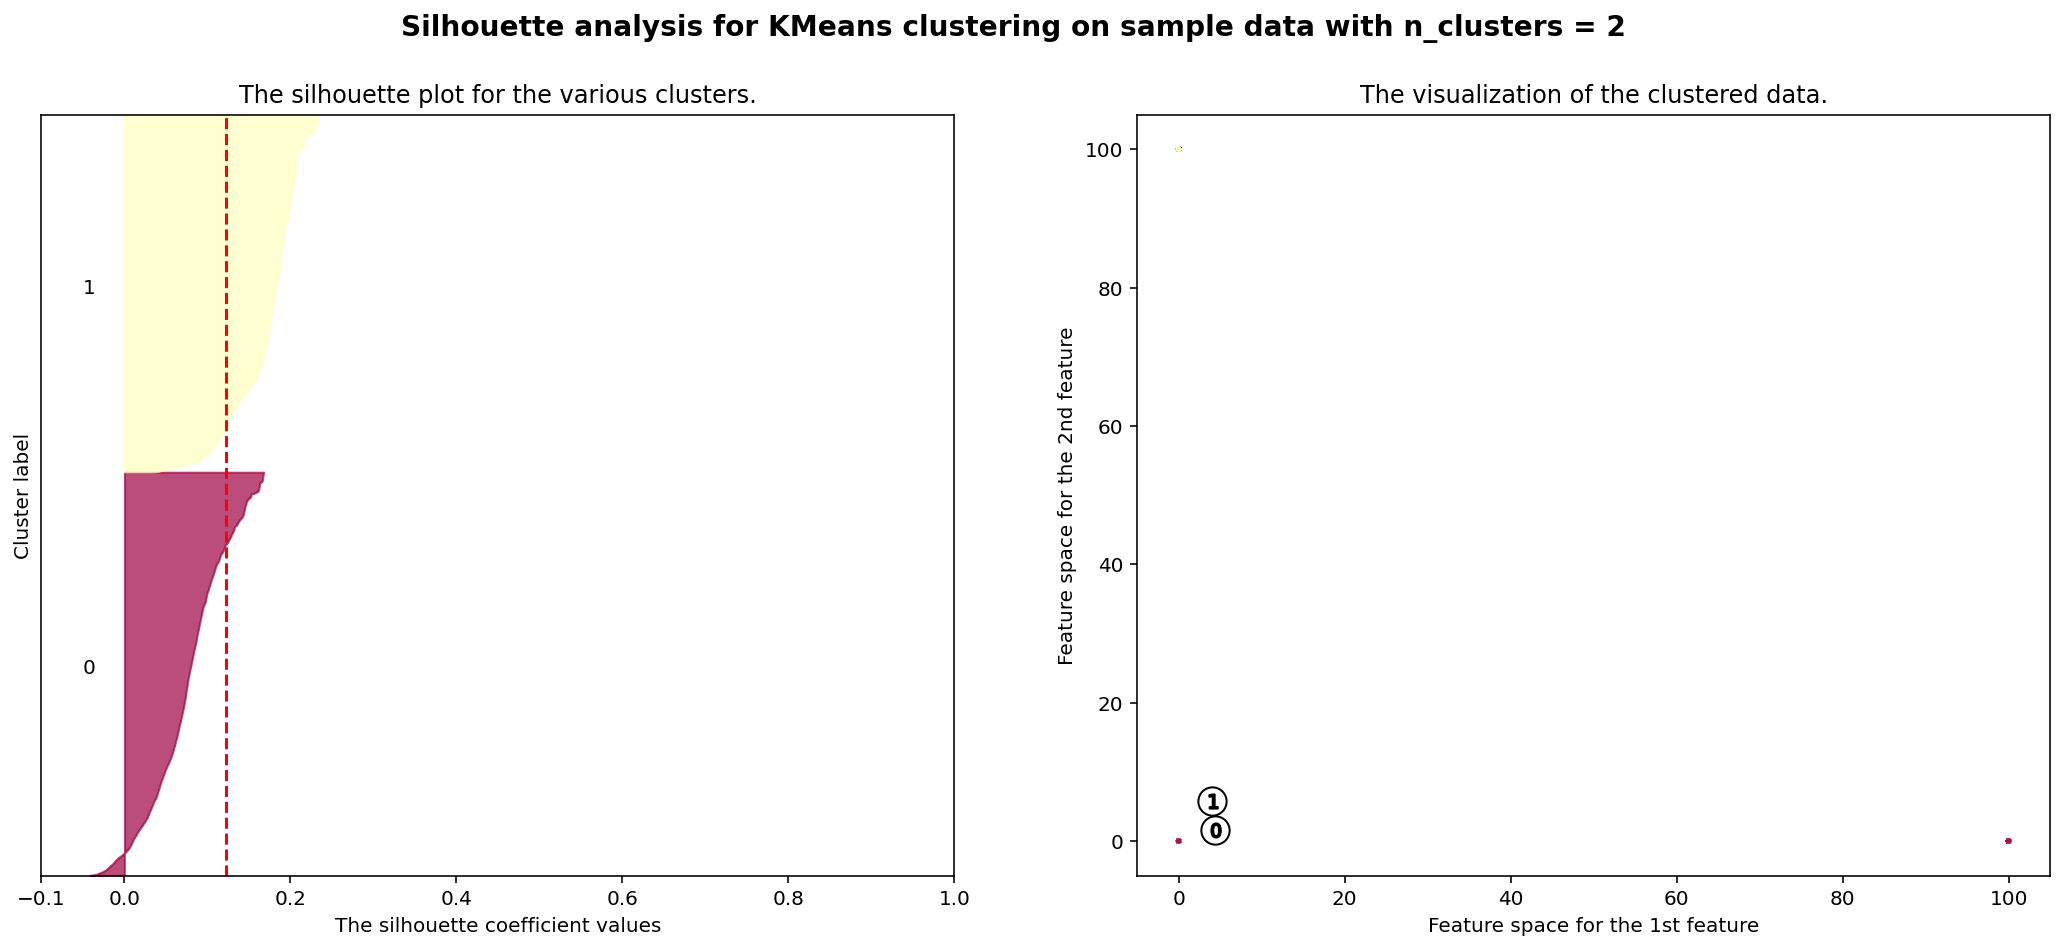

NMI score: 0.113909
For n_clusters = 4 The average silhouette_score is : 0.11846864360070651


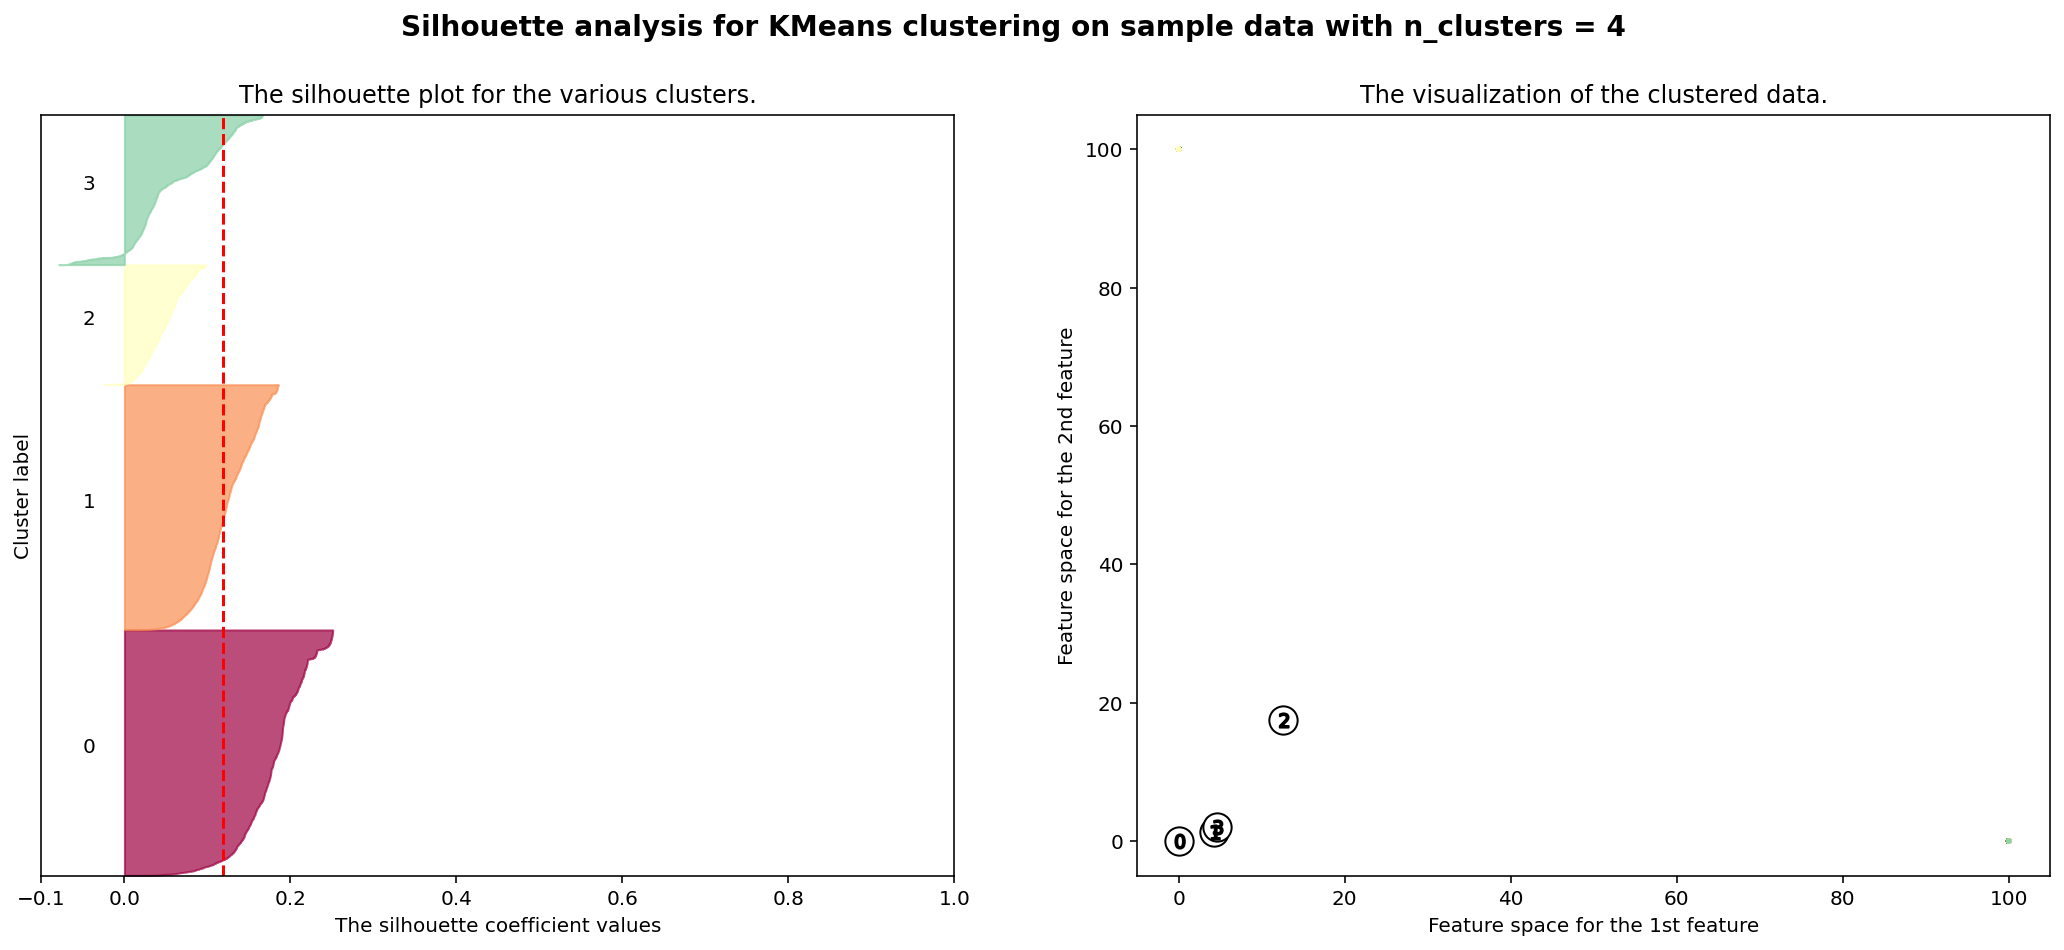

NMI score: 0.100114
For n_clusters = 6 The average silhouette_score is : 0.07473762703334465


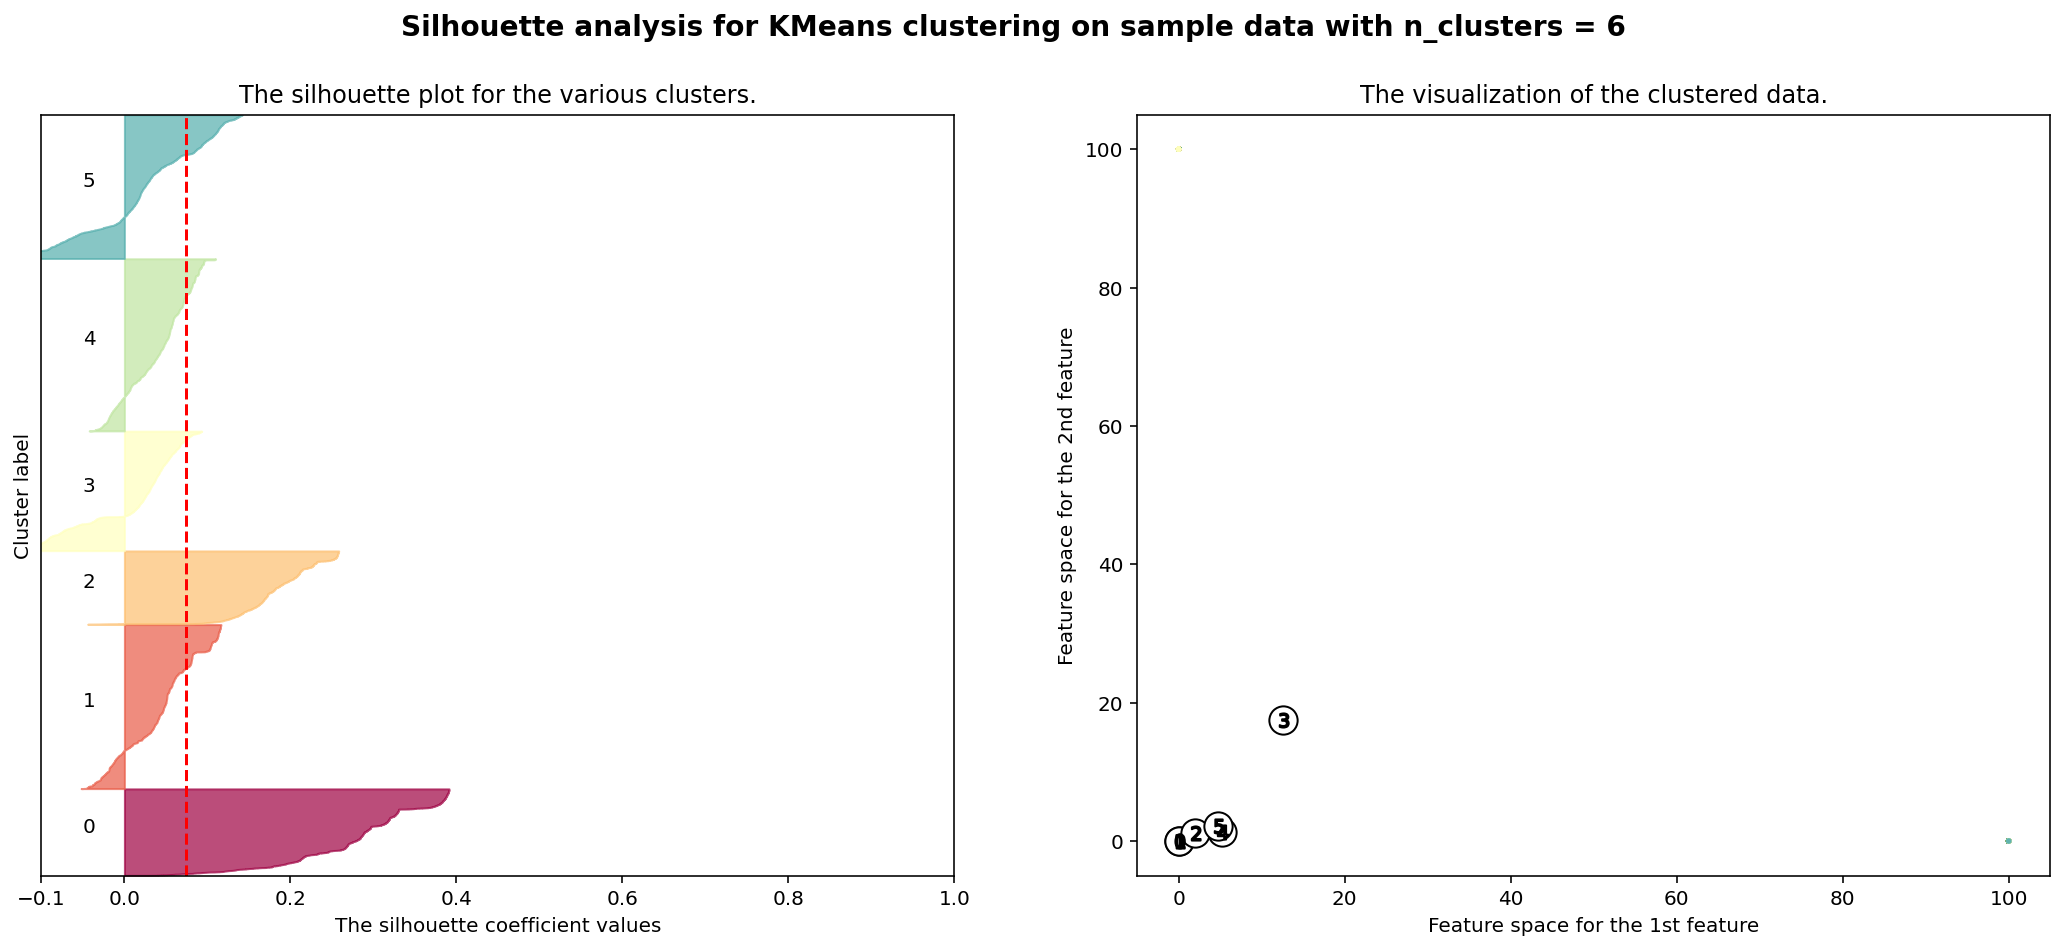

In [28]:
range_n_clusters = [2,4,6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.labels_
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter( X_norm.iloc[:, 10], X_norm.iloc[:, 8], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 10], centers[:, 8], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter( c[10], c[8], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


NMI score: 0.169302


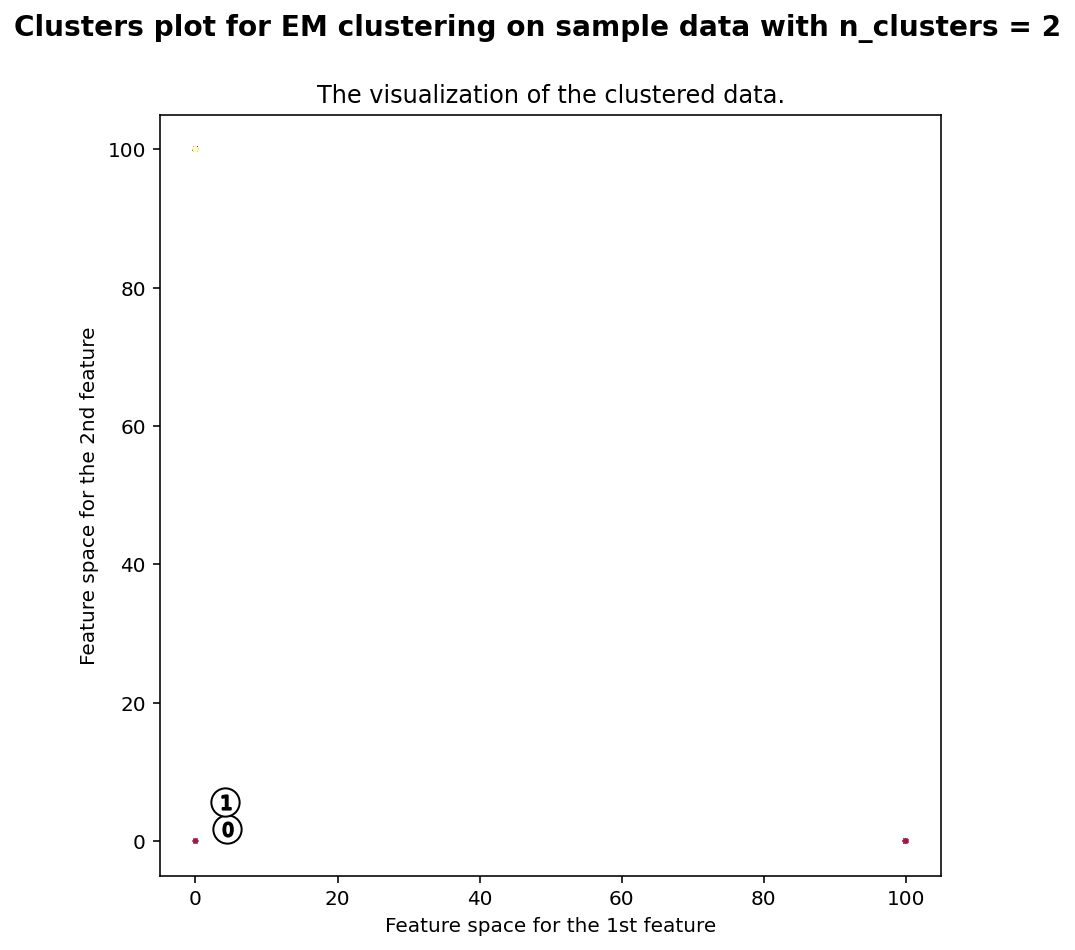

NMI score: 0.066100


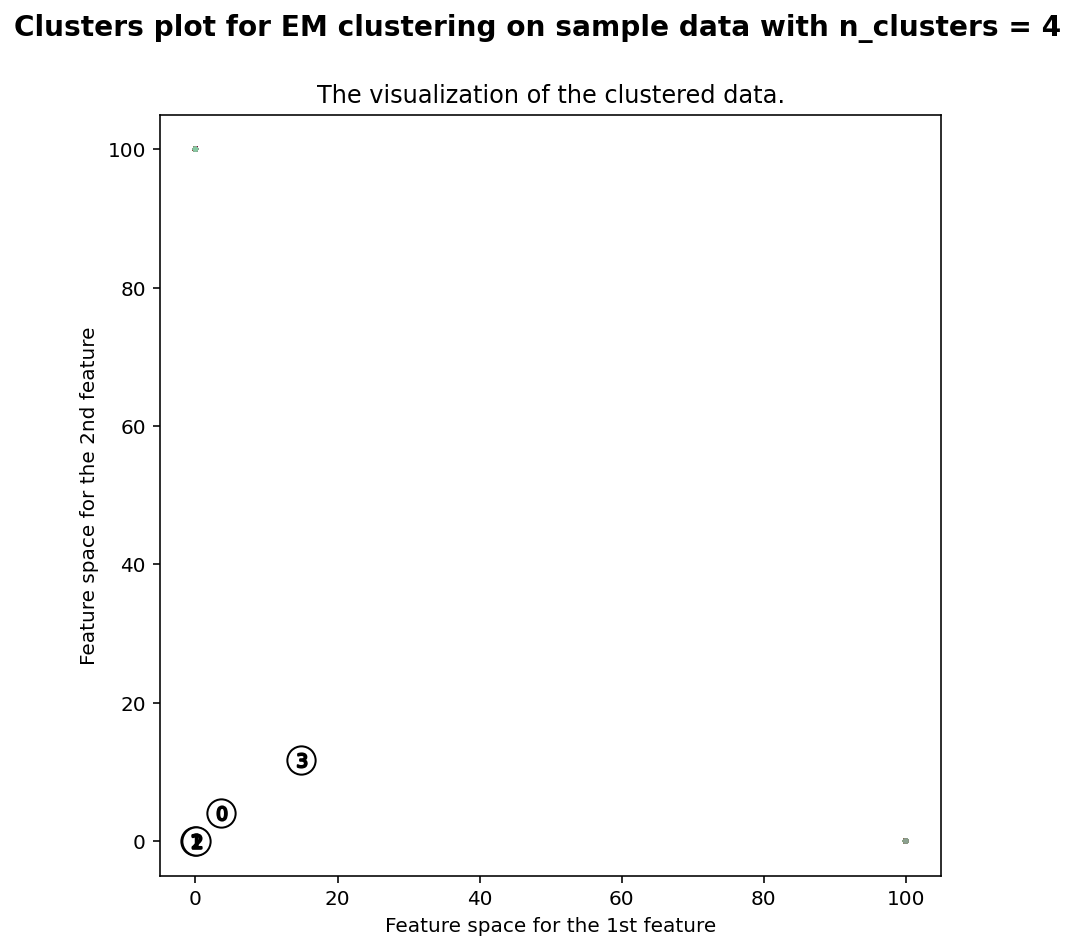

NMI score: 0.092038


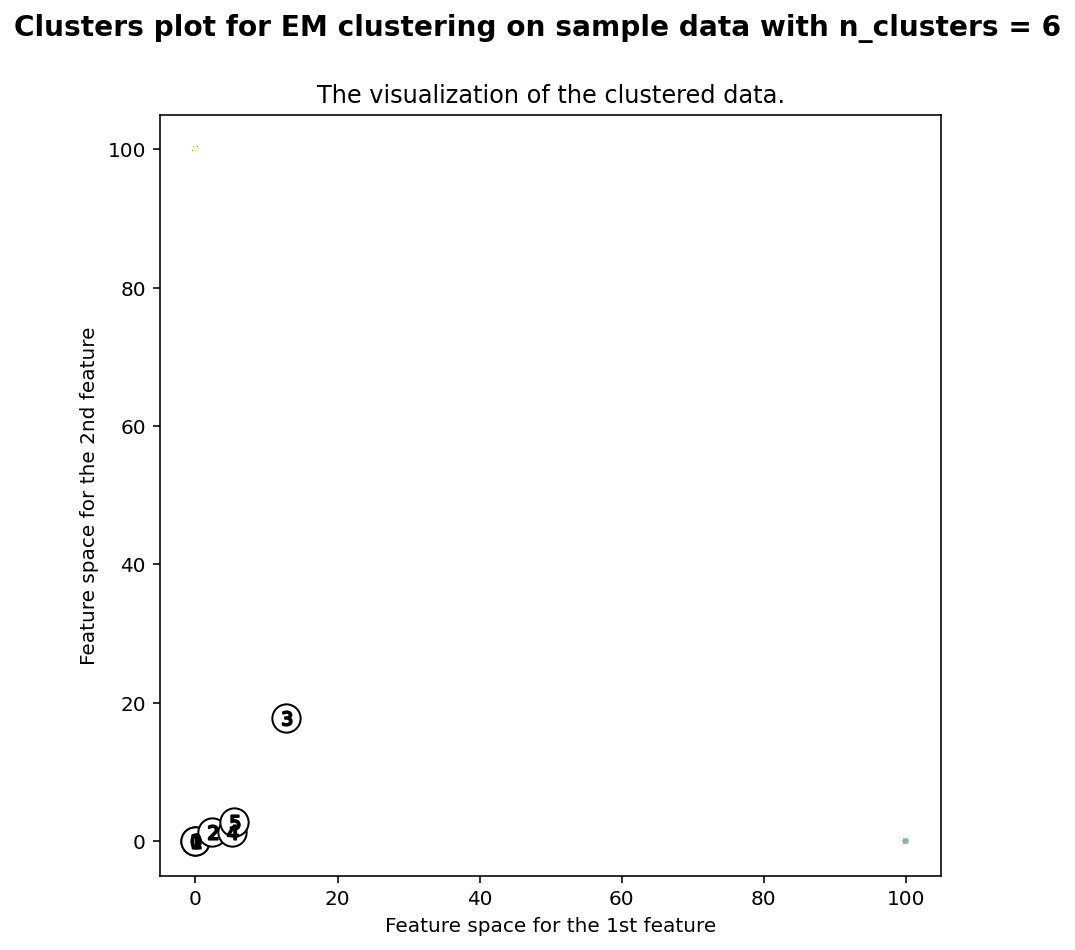

In [29]:
#Expectation Maximization clustering

for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.predict(X_norm)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    # 2nd Plot showing the actual clusters formed
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_norm.iloc[:, 10], X_norm.iloc[:, 8], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 10], centers[:, 8], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[10], c[8], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

explained variance ratio (first two components): [9.98016209e-01 1.09185944e-03 8.33341927e-04 3.92263486e-05
 2.34299830e-06 1.59677521e-06 1.37816430e-06 1.19648821e-06
 1.14178410e-06 1.01006701e-06 8.49777627e-07]


Text(0.5, 1.0, 'PCA of Wine Quality dataset')

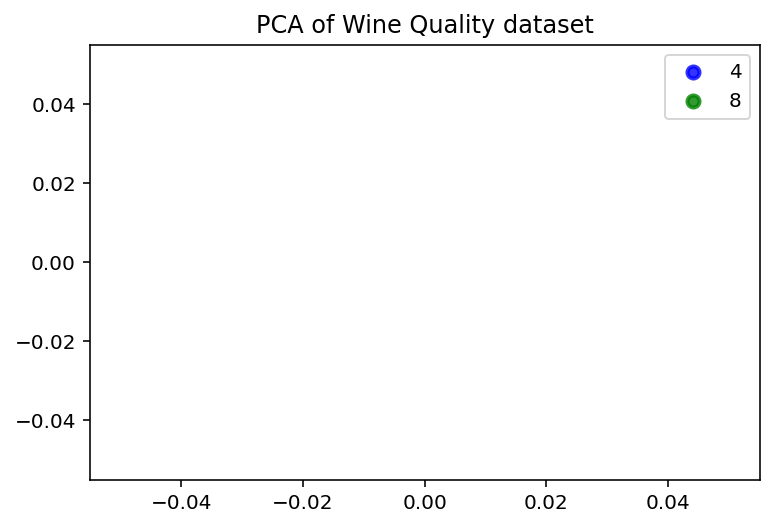

In [40]:
#PCA feature transformation

pca = PCA(n_components=11, random_state=10)
X_r = pca.fit(X).transform(X)
X_pca = X_r
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ["b","g","r","c","m","y","k"]
lw = 2

for color, i in zip(colors, [4,8]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Wine Quality dataset')

In [47]:

def principalComponentAnalysis(data, n_components):
    pc = PCA(n_components = n_components, random_state= 42).fit_transform(data)
    
    varianceExplained = {}
    
    explained_variance = np.var(pc, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    pcaCumSum = np.cumsum(explained_variance_ratio)
    
    for iterComp in range(n_components):
        varianceExplained[iterComp] = pcaCumSum[iterComp]
    
    plt.figure()
    plt.plot(list(varianceExplained.keys()), list(varianceExplained.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")    

    return plt, varianceExplained, pc

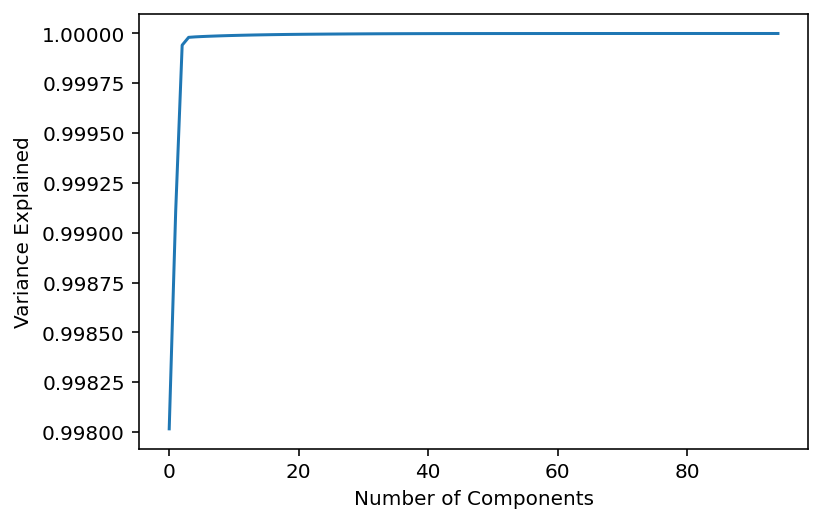

In [48]:
#scaler = preprocessing.MinMaxScaler()
#x, y = loadCSVData("winequality-white.csv", "GoodQuality")
n_components = len(X.columns)

plt, varianceExplained, pca = principalComponentAnalysis(X, n_components)
plt.show()

# Part 1

Run the clustering algorithms on the datasets and describe what you see. 

Compare clustering algorithms
 
Choosing and justifying a distance and similarity metric when you're computing clustering.

## K-means clustering 

In [1237]:
n_clusters = np.hstack((np.arange(2, 10), np.arange(10, 21, 2), np.array([25, 30, 35, 40]))).astype(np.int)
print(n_clusters)

[ 2  3  4  5  6  7  8  9 10 12 14 16 18 20 25 30 35 40]


In [1238]:
km_res = defaultdict(dict)
for k in tqdm(n_clusters):
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(X)
    y_km = km.predict(X)
    km_res[k]['dist'] = km.inertia_
    #km_res[k]['time'] = t
    km_res[k]['sil'] = silhouette_score(X, y_km, random_state=42)
    km_res[k]['ami'] = ami(y, y_km)

100%|██████████| 18/18 [03:23<00:00, 11.28s/it]


In [1239]:

"""
def save_cluster_result(results, dataset, algorithm, extras=''):
    filepath = '%s_%s_%s.pkl' % (dataset, algorithm, extras)
    save_to_file(results, filepath)


def load_cluster_result(dataset, algorithm, extras=None):
    if extras:
        filepath = '%s_%s_%s.pkl' % (dataset, algorithm, extras)
    else:
        filepath = '%s_%s.pkl' % (dataset, algorithm)
    return load_from_file(filepath)


def load_from_file(filepath):
    with open(filepath, 'rb') as fp:
        result = pickle.load(fp)
    return result
def save_to_file(obj, filepath):
    with open(filepath, 'wb') as fp:
        pickle.dump(obj, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
save_cluster_result(km_res, 'd', 'km')
km_res = load_cluster_result('d', 'km')
"""

"\ndef save_cluster_result(results, dataset, algorithm, extras=''):\n    filepath = '%s_%s_%s.pkl' % (dataset, algorithm, extras)\n    save_to_file(results, filepath)\n\n\ndef load_cluster_result(dataset, algorithm, extras=None):\n    if extras:\n        filepath = '%s_%s_%s.pkl' % (dataset, algorithm, extras)\n    else:\n        filepath = '%s_%s.pkl' % (dataset, algorithm)\n    return load_from_file(filepath)\n\n\ndef load_from_file(filepath):\n    with open(filepath, 'rb') as fp:\n        result = pickle.load(fp)\n    return result\ndef save_to_file(obj, filepath):\n    with open(filepath, 'wb') as fp:\n        pickle.dump(obj, fp, protocol=pickle.HIGHEST_PROTOCOL)\n        \nsave_cluster_result(km_res, 'd', 'km')\nkm_res = load_cluster_result('d', 'km')\n"

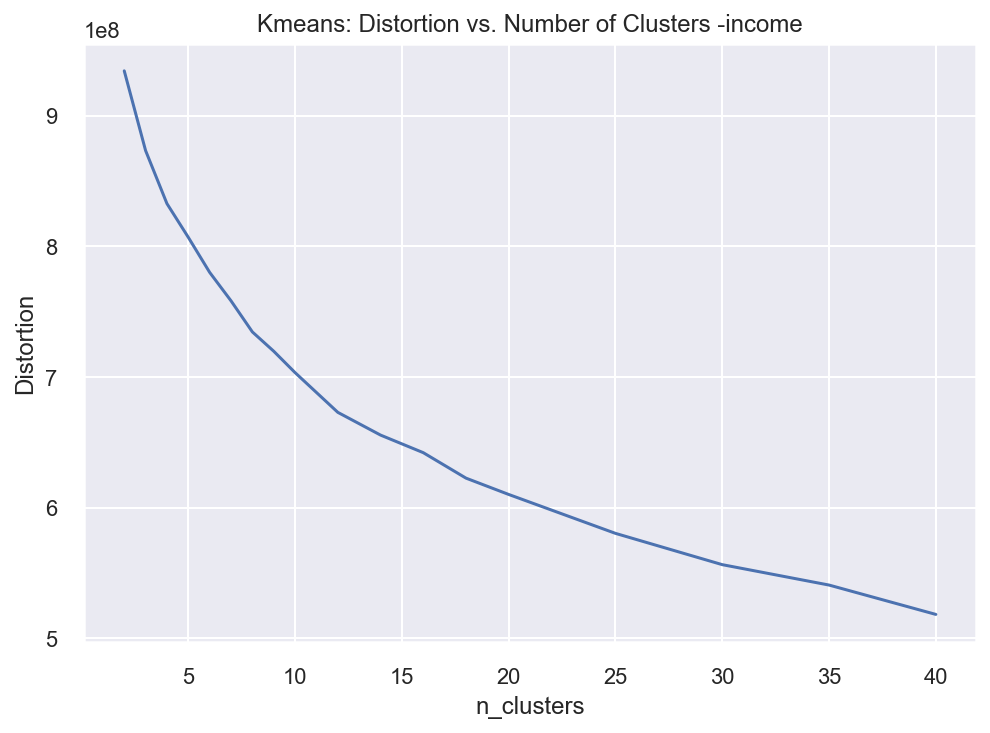

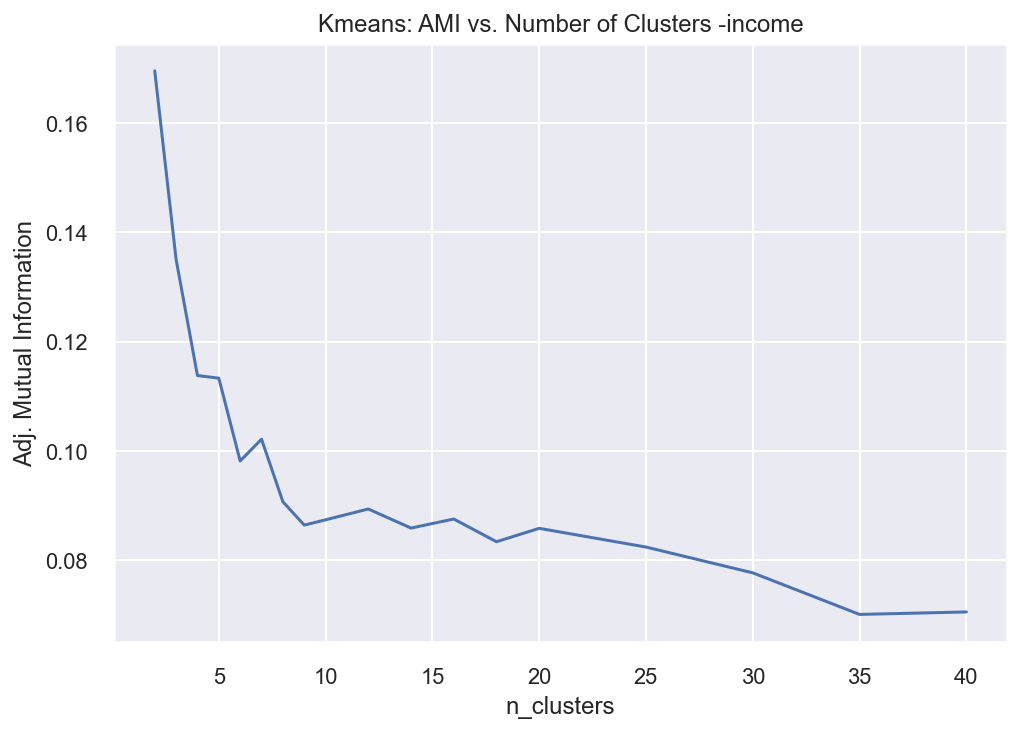

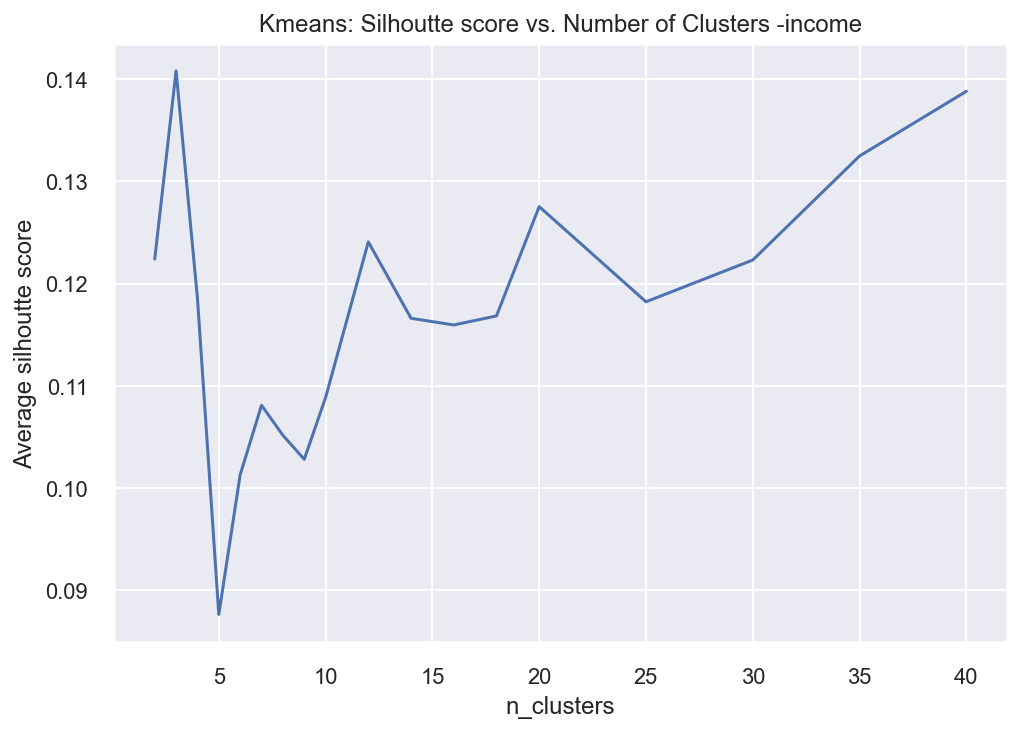

In [1240]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.title('Kmeans: Distortion vs. Number of Clusters -'+str(ds_name))
plt.show()

plt.plot(n_clusters, [km_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.title('Kmeans: AMI vs. Number of Clusters -'+str(ds_name))
plt.show()

plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.title('Kmeans: Silhoutte score vs. Number of Clusters -'+str(ds_name))
plt.show()

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Silhouette Coefficient:   
A higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:
1. The mean distance between a sample and all other points in the same class.
2. The mean distance between a sample and all other points in the next nearest cluster.

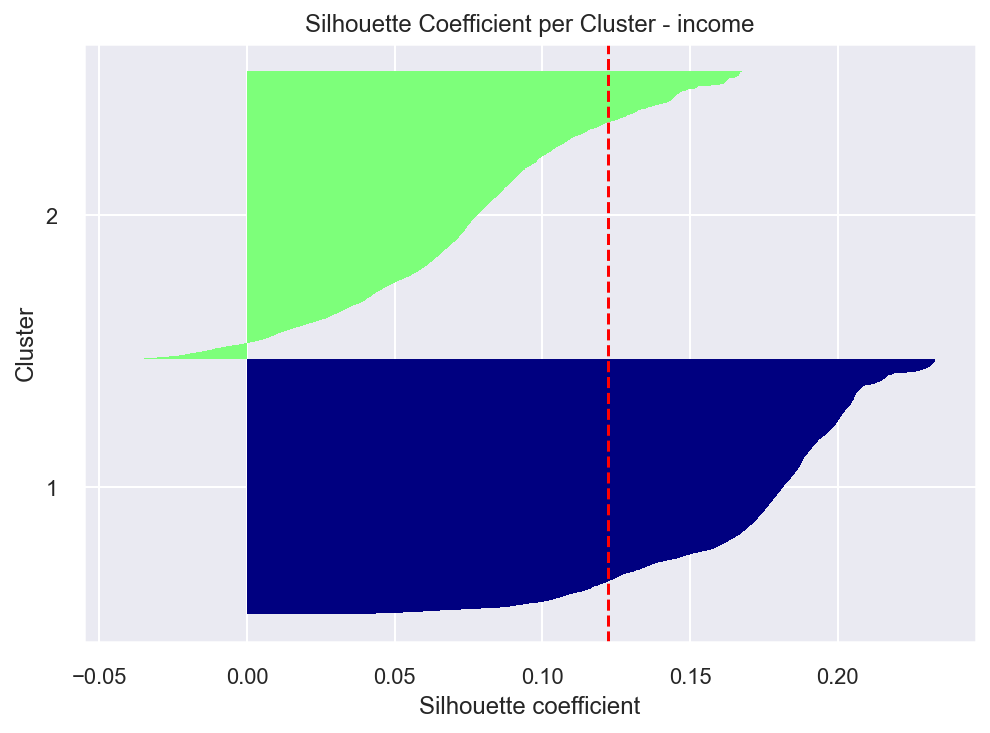

In [1133]:
km = KMeans(n_clusters=2, random_state=42)
y_km = km.fit_predict(X)
cluster_labels = np.unique(y_km)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title('Silhouette Coefficient per Cluster - '+str(ds_name))
plt.show()

In [1124]:
km_df = X.copy()
km_df['label'] = y_km

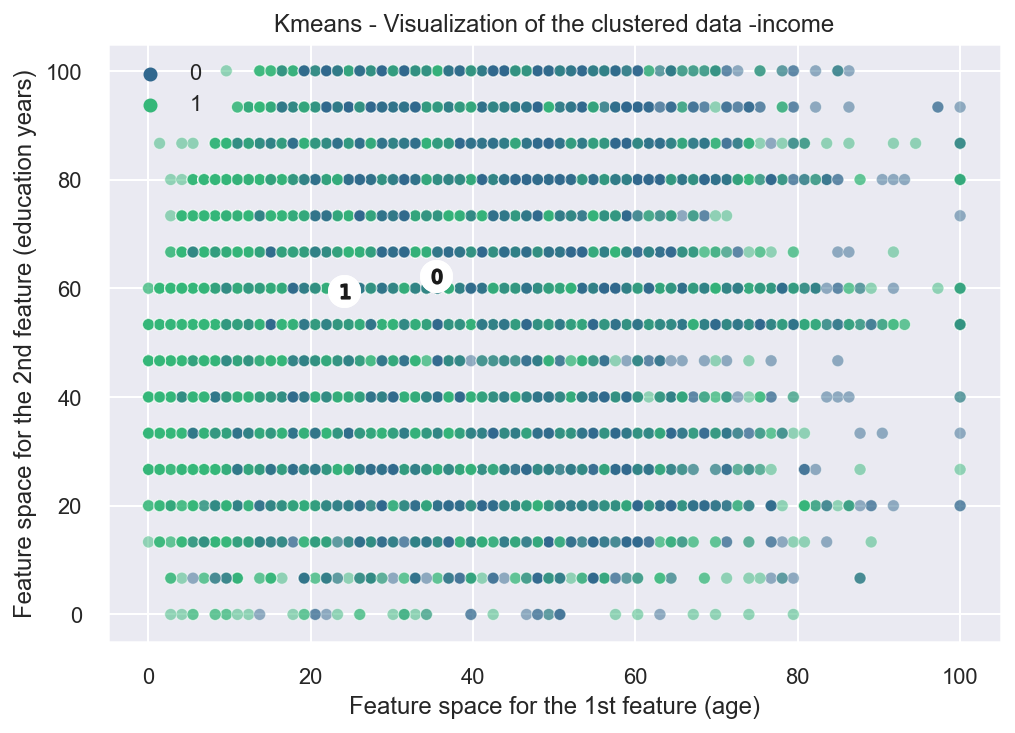

In [1134]:
sns.scatterplot(x =X['age'], y= X['education.num'], hue=y_km, palette='viridis', alpha=0.5,legend='full')
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=240, alpha=1, marker='o')
centers = km.cluster_centers_

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], c='white', s=240, alpha=1, marker='o')
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title("Kmeans - Visualization of the clustered data -"+str(ds_name))
plt.xlabel("Feature space for the 1st feature (age)")
plt.ylabel("Feature space for the 2nd feature (education years)");

## EM

In [142]:
def EM(X):

    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; training_times = []; aic_scores = []; bic_scores = []
    
    for n in tqdm(kdist):
        em = GaussianMixture(n_components=n,covariance_type='full',n_init=1,warm_start=True,random_state=32).fit(X)
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
    return homo_scores, aic_scores, bic_scores

In [143]:
homo_scores, aic_scores, bic_scores = EM(X)

100%|██████████| 20/20 [20:12<00:00, 60.64s/it] 


In [1130]:
em_res = defaultdict(dict)
for k in tqdm(n_clusters):
    gm = GaussianMixture(
        n_components=k,
        random_state=42,
        n_init=1,
        init_params='kmeans',
    )
    gm.fit(X)
    y_gm = gm.predict(X)
    em_res[k]['bic'] = gm.bic(X)
    em_res[k]['aic'] = gm.aic(X)
    em_res[k]['ll'] = gm.score(X)
    #em_res[k]['time'] = t
    em_res[k]['sil'] = silhouette_score(X, y_gm, random_state=42)
    em_res[k]['ami'] = ami(y, y_gm)

100%|██████████| 18/18 [07:06<00:00, 23.68s/it]


In [154]:
def balanced_accuracy(truth,pred):
    wts = compute_sample_weight('balanced',truth)
    return accuracy_score(truth,pred,sample_weight=wts)

balanced_accuracy_scorer = make_scorer(balanced_accuracy)

em2 = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_em = em2.fit_predict(X)
balanced_accuracy(pred=y_em, truth=y)

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0.5343808251334535

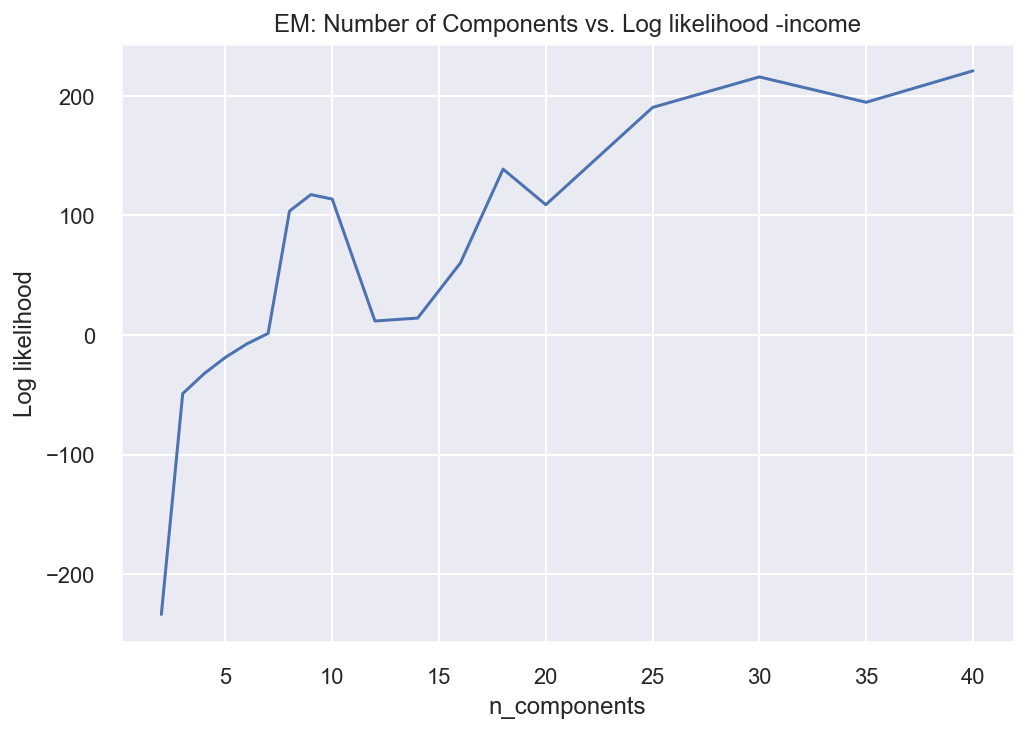

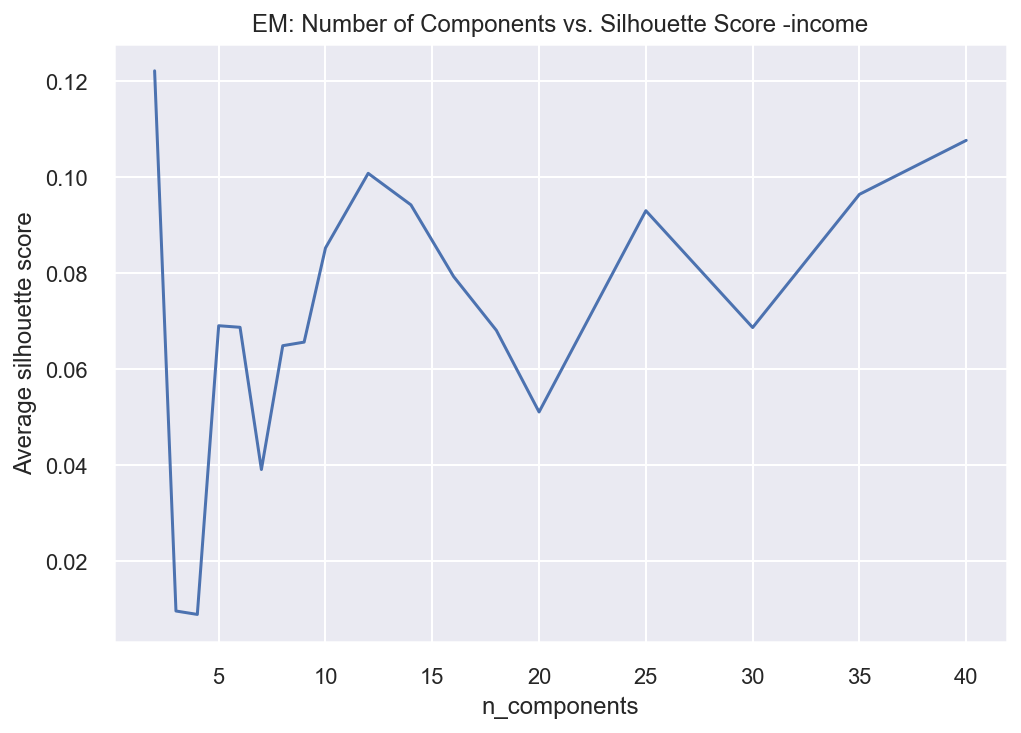

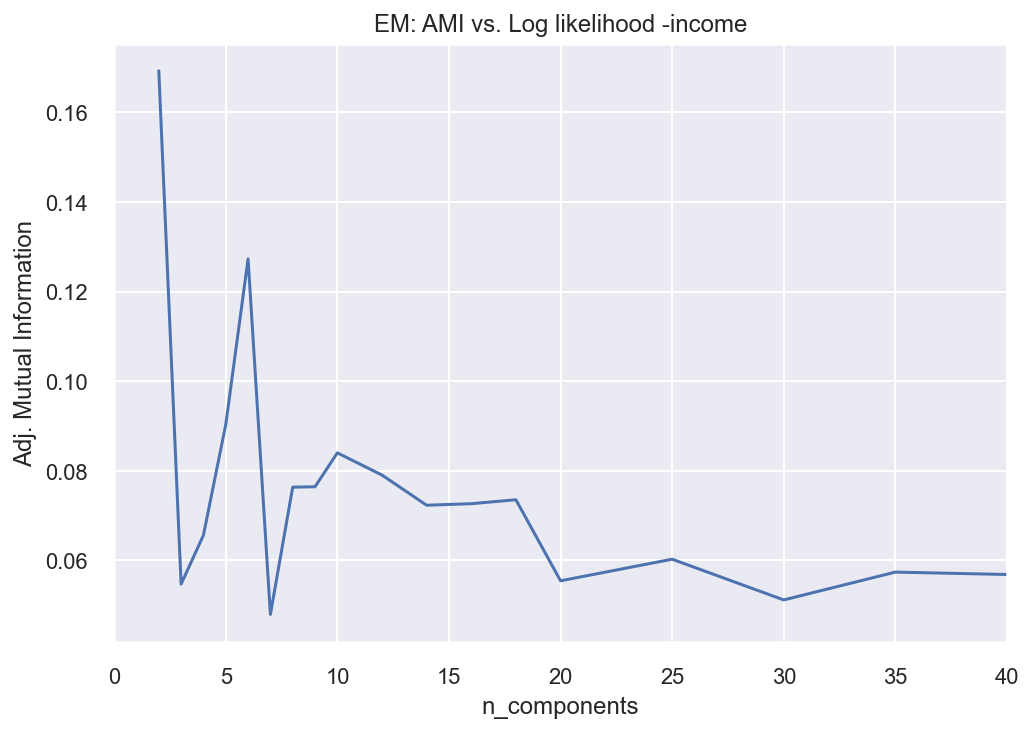

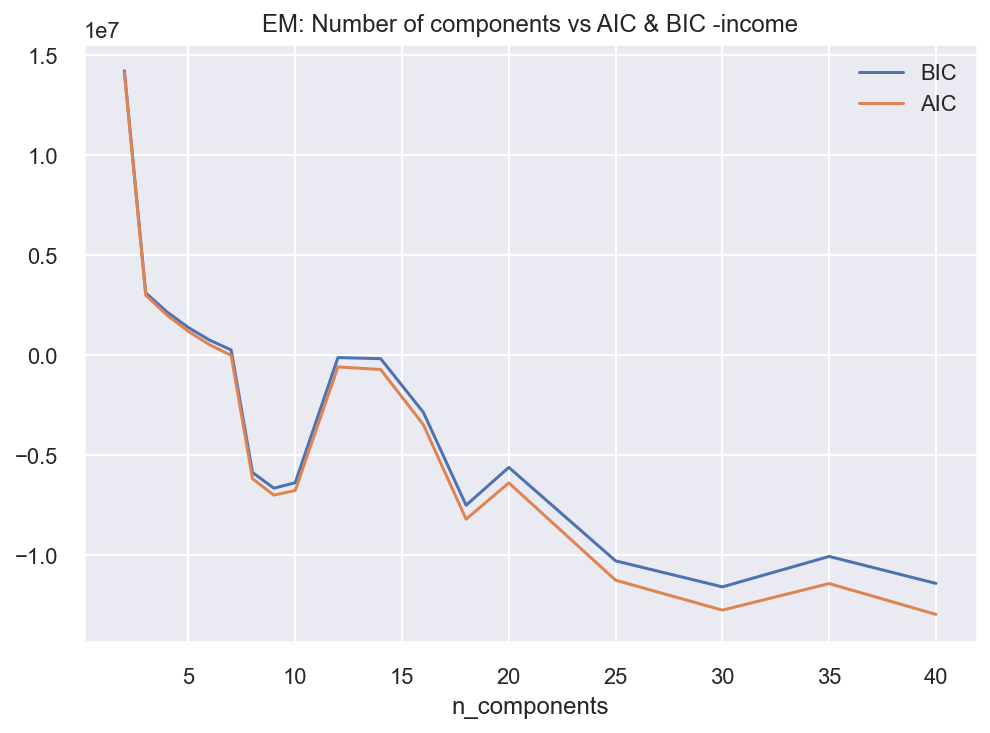

In [1137]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.title('EM: Number of Components vs. Log likelihood -'+str(ds_name))
plt.show()

plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.title('EM: Number of Components vs. Silhouette Score -'+str(ds_name))
plt.show()

plt.plot(n_clusters, [em_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Adj. Mutual Information')
plt.title('EM: AMI vs. Log likelihood -'+str(ds_name))
plt.xlim([0, 40])
plt.show()

plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('EM: Number of components vs AIC & BIC -'+str(ds_name))
plt.show()

* BIC - Bayesian information criterion for the current model on the input X. (The lower the better.) 
* AIC - Akaike information criterion for the current model on the input X. (The lower the better.) 

In [1139]:
gm = GaussianMixture(
        n_components=2,
        random_state=42,
        n_init=1,
        init_params='kmeans')
gm.fit(X)

GaussianMixture(n_components=2, random_state=42)

In [1140]:
y_gm = gm.predict(X)

In [1141]:
gm.means_[:,0]

array([24.18139686, 35.30175457])

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


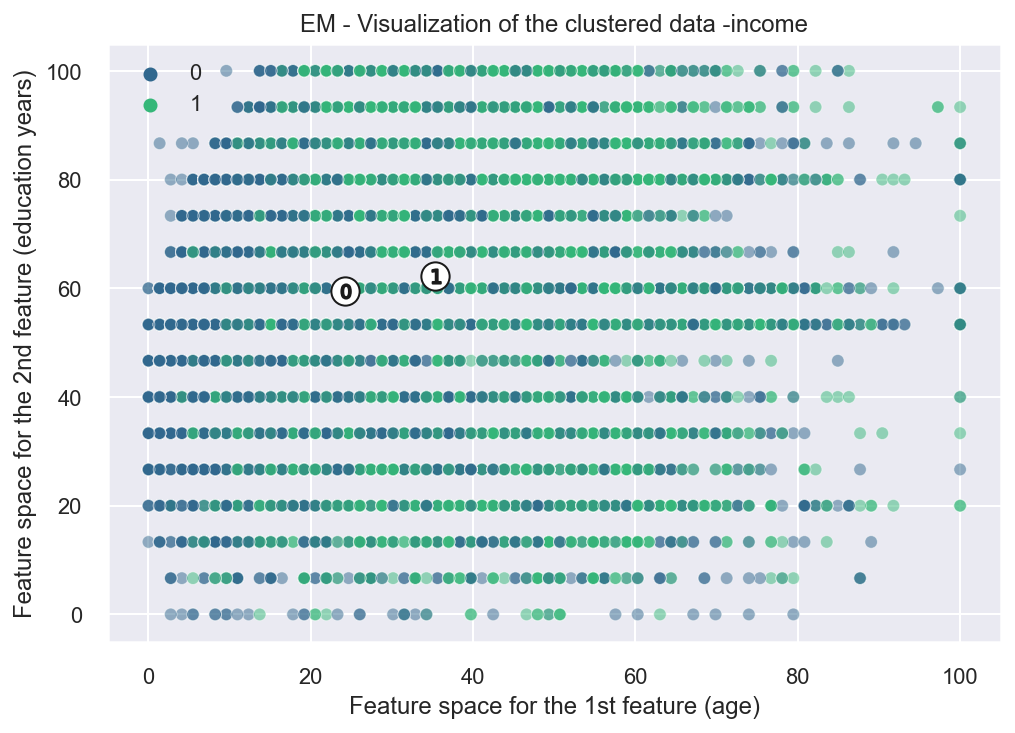

In [1142]:
sns.scatterplot(X['age'], X['education.num'], hue=y_gm, s=40, palette='viridis', alpha=0.5, legend='full')
# Labeling the clusters

centers = gm.means_


# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
plt.title("EM - Visualization of the clustered data -"+str(ds_name))
plt.xlabel("Feature space for the 1st feature (age)")
plt.ylabel("Feature space for the 2nd feature (education years)");

# Part 2

Apply the dimensionality reduction algorithms to the two datasets and describe what you see. 
1. PCA
2. ICA
3. Randomized projections
4. Random Forests 

## PCA

**PCA is capturing largest amount of variance in the data.**


In [1213]:
pca = PCA(
    n_components=None, #if n_components is not set all components are kept:: 
    random_state=42,
)
pca.fit(X)

PCA(random_state=42)

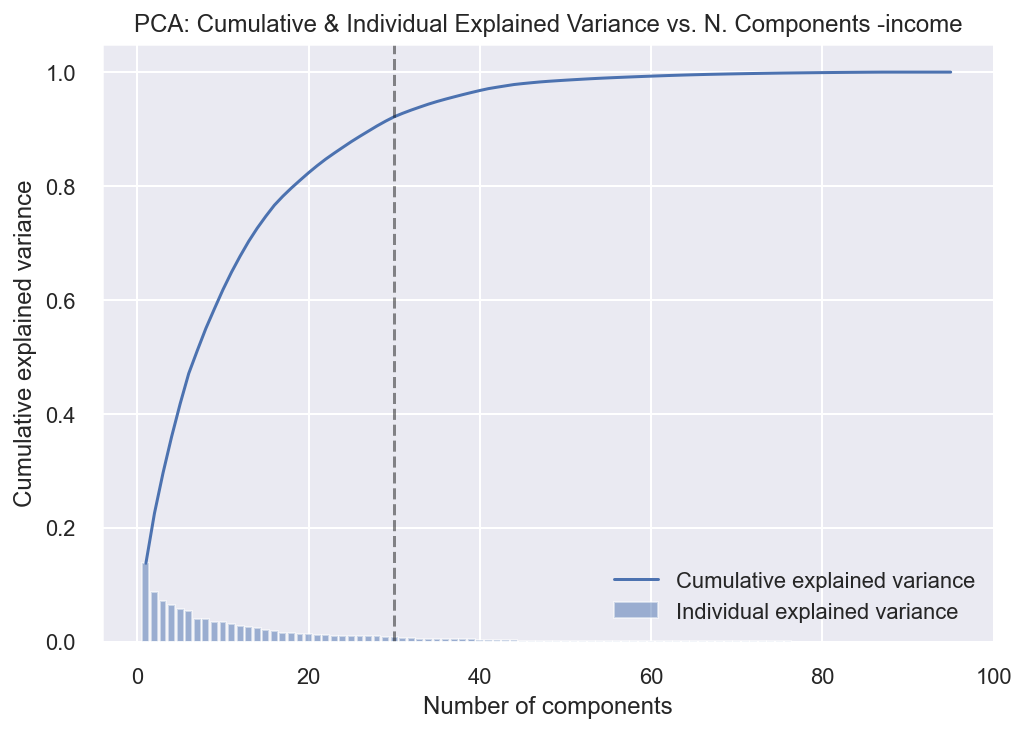

<Figure size 432x288 with 0 Axes>

In [1222]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), label='Cumulative explained variance')
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.legend()
plt.title('PCA: Cumulative & Individual Explained Variance vs. N. Components -'+str(ds_name))


plt.axvline(30, linestyle='--', color='k', alpha=0.5)
plt.figure(figsize=(6,4));

In [1223]:
round(np.cumsum(pca.explained_variance_ratio_)[30]*100,3)

92.776

## TSNE after PCA 

In [1202]:
df_subset = pd.DataFrame()
#data_subset = df_subset[feat_cols].values
pca = PCA(n_components=20)
pca_result = pca.fit_transform(X)
#df_subset['pca-one'] = pca_result[:,0]
#df_subset['pca-two'] = pca_result[:,1] 
#df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))



Explained variation per principal component: [0.13753618 0.08781068 0.07079168 0.06348588 0.05792797 0.0531536
 0.04026244 0.03885395 0.03451524 0.03364713 0.03074228 0.02799218
 0.02605195 0.02317476 0.02081916 0.01946262 0.0158981  0.01443005
 0.01342134 0.01312673]


In [1204]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(pca_result)
X_embedded.shape

(30162, 2)

In [1205]:
#df_subset = pd.DataFrame()
#df_subset['y'] = y

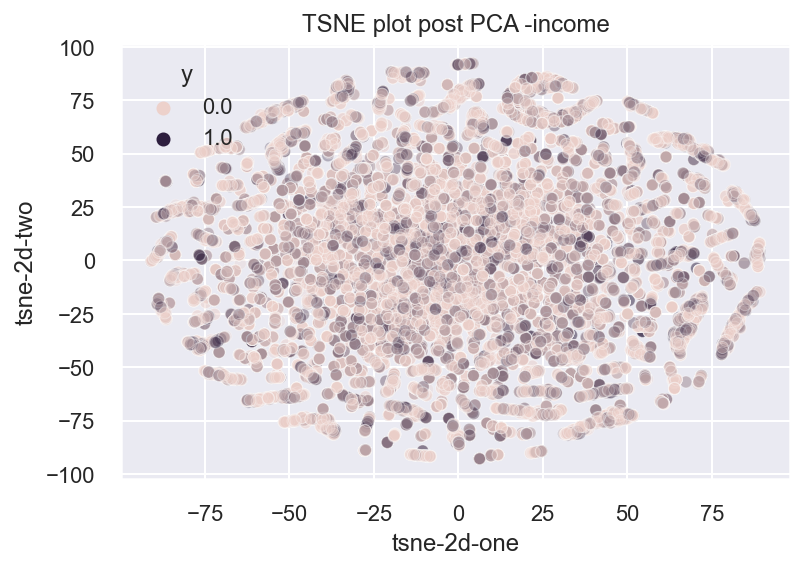

In [1211]:
tsne_results = X_embedded.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = y
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.title('TSNE plot post PCA -'+str(ds_name));

In [170]:
pca = PCA(
    n_components=6,
    random_state=0,
)
pca.fit(X)

PCA(n_components=6, random_state=0)

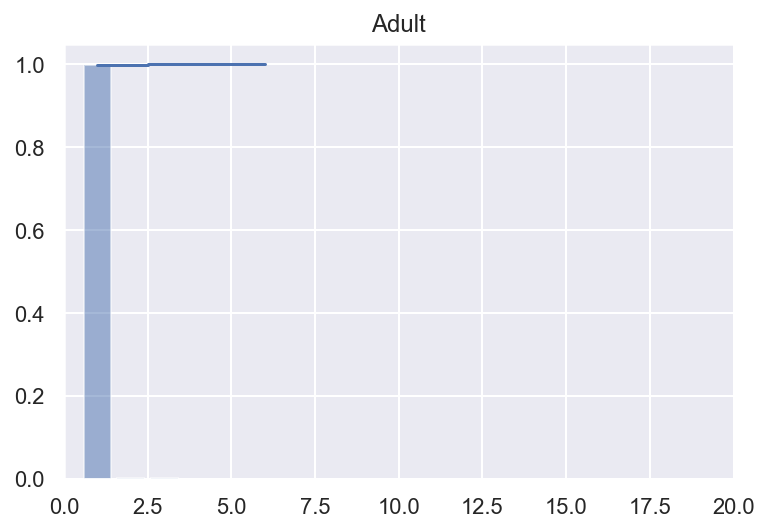

In [171]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 20])
plt.title('Adult')
plt.show()

### ICA
**ICA is finding independent components with kurtosis. Kurtosis: higher values indicate the presence of tail extremity, i.e. more data outside of the peak. It's a measure of non-gaussianity and is the basis of ICA.**

In [1146]:
a, b= np.arange(1, 21,1),np.arange(30,110,10)
component_counts = np.concatenate((a,b), axis=None)

total_kurtosis = {}

for component_count in component_counts:
    tmp_ica = FastICA(
        random_state=42,
        n_components=component_count,
    )
    tmp_X_tr = tmp_ica.fit_transform(X)
    total_kurtosis[component_count] = np.abs(kurtosis(tmp_X_tr, axis=0)).sum()

#pprint(total_kurtosis)

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 95
  warnings.warn(
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did 

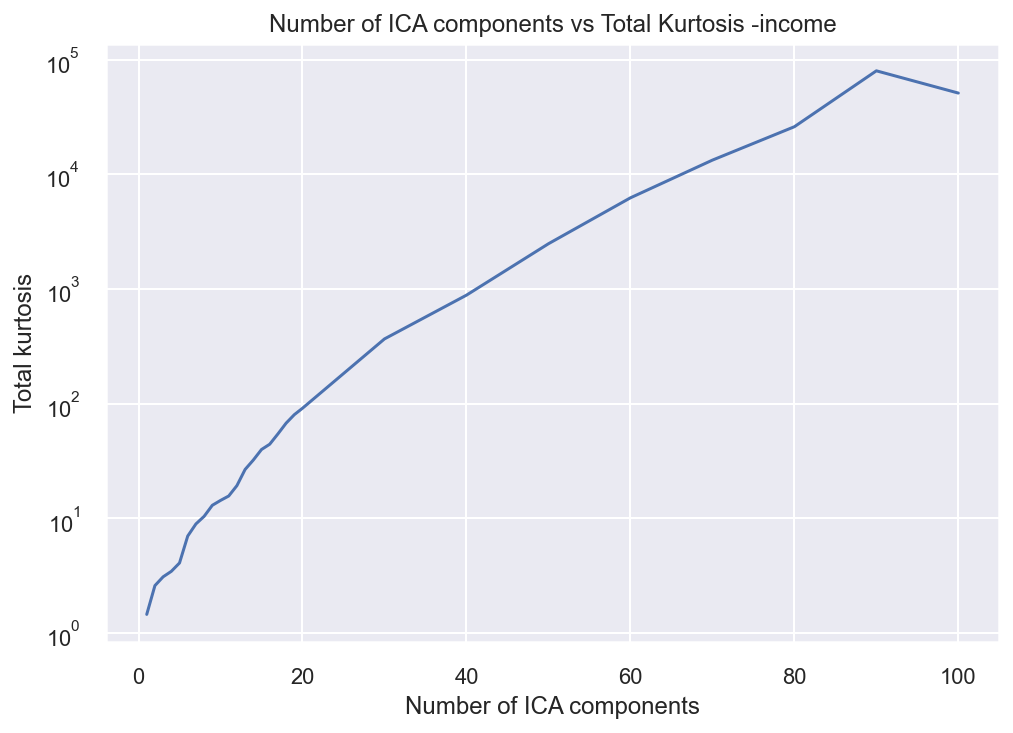

In [1147]:
pd.Series(total_kurtosis).plot()
plt.ylabel('Total kurtosis')
plt.xlabel('Number of ICA components')
plt.title('Number of ICA components vs Total Kurtosis -'+str(ds_name))
plt.semilogy();

In [1148]:
ica10 = FastICA(
    random_state=42,
    n_components=10,
)
X_tr10 = ica10.fit_transform(X)
kurt_df10 = pd.DataFrame(kurtosis(X_tr10, axis=0), columns=['kurtosis'])
kurt_df10.sort_values(by='kurtosis', ascending=False)

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


kurtosis
9  2.845013
0  2.587862
8  1.910726
5  1.288822
7  1.079199
4  0.349323
1 -0.586511
6 -0.615980
3 -1.425963
2 -1.675751

### Randomized Projections 

In [1149]:
def randomProjections(data, n_components):
    pWDC = {}
    rError = {}
    
    for iterN in range(1, n_components):
        rp = SparseRandomProjection(n_components = iterN, random_state= 42)
        
        rpCopy = rp
        pWDC[iterN] = pairwiseDistCorr(rp.fit_transform(data), data)
        
        rpCopy.fit(data)
        rError[iterN] = reconstructionError(rpCopy, data)
    
    
    plt.subplot(2, 1, 1)
    plt.plot(list(pWDC.keys()), list(pWDC.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Pair-wise Distance Correlation")     
    
    plt.subplot(2, 1, 2)
    plt.plot(list(rError.keys()), list(rError.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error")     

    return plt, pairwiseDistCorr, reconstructionError, rp

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)


In [1150]:
dims = list(np.arange(2,(X.shape[1]-1),3))
dims.append(X.shape[1])
tmp = defaultdict(dict)

In [216]:
    for i,dim in tqdm(product(range(5),dims)):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()

15it [25:18, 101.24s/it]


In [686]:
rp = RCA(random_state=i, n_components=30)
tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
tmp = pd.DataFrame(tmp).T

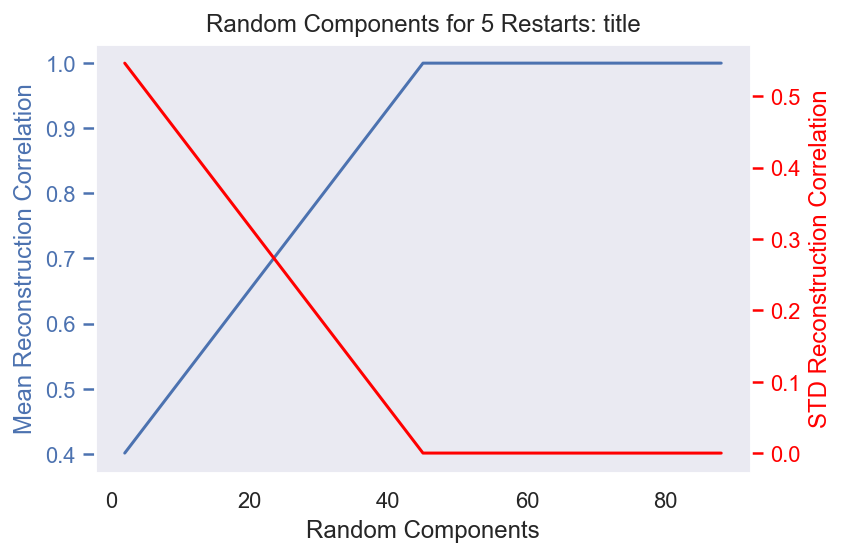

In [222]:
    title = 'title'
    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'red')
    ax2.set_ylabel('STD Reconstruction Correlation', color='red')
    ax2.tick_params('y', colors='red')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

In [531]:
def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in tqdm(product(range(5),dims)):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

160it [4:20:59, 97.87s/it]


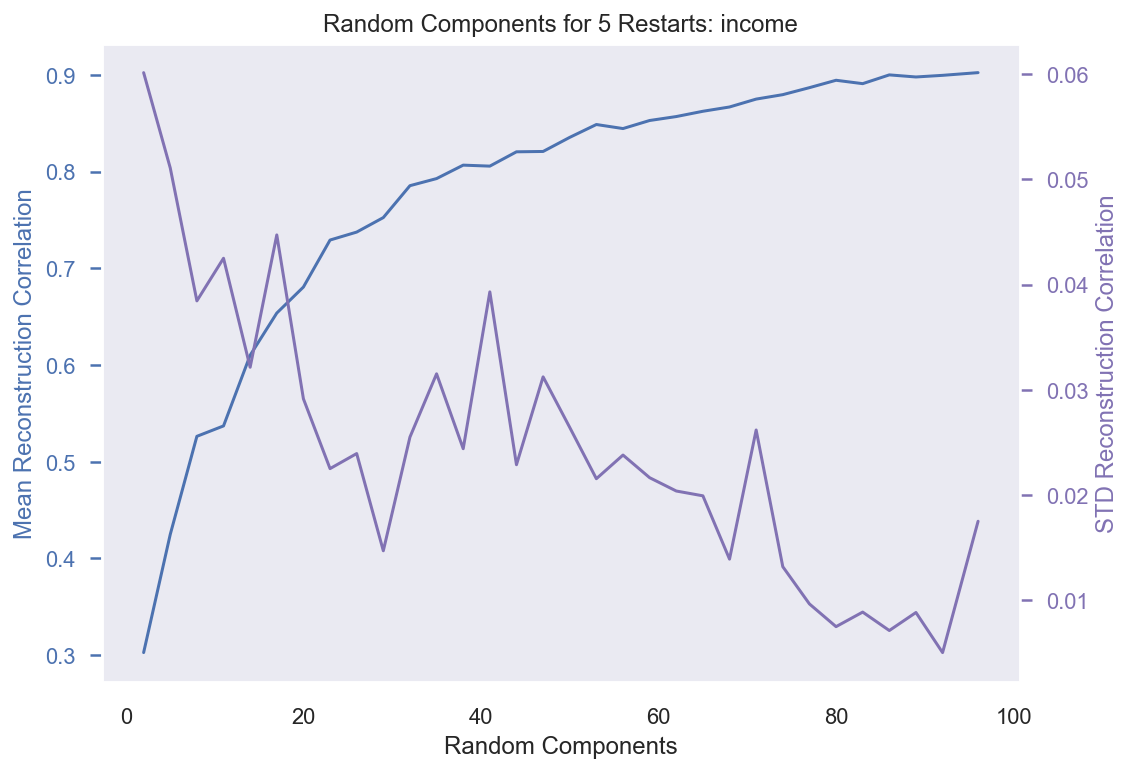

In [998]:
run_RCA(X,y, 'income')

## Random Forests Classifier

In [1151]:
def run_RFC(X,y):
    rfc = RFC(n_estimators=200,min_samples_leaf=round(len(X)*.01),random_state=42,n_jobs=-1, max_depth=5)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=X.columns)
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

In [1152]:
X.columns=features

In [1153]:
importance, top_columns = run_RFC(X,y)
print('We see that '+str(len(importance))+' features give a cumulative sum of '+str(round(importance['Cum Sum'][-1],2)))
importance

We see that 14 features give a cumulative sum of 0.95


Feature Importance   Cum Sum
marital.status_Married-civ-spouse            0.254821  0.254821
education.num                                0.149284  0.404104
marital.status_Never-married                 0.100941  0.505045
age                                          0.090341  0.595387
sex                                          0.054643  0.650029
hours.per.week                               0.052545  0.702574
occupation_Exec-managerial                   0.052383  0.754957
capital.loss                                 0.039145  0.794102
occupation_Prof-specialty                    0.034749  0.828852
education_Bachelors                          0.031774  0.860626
education_Masters                            0.030758  0.891383
marital.status_Divorced                      0.019622  0.911005
occupation_Other-service                     0.018532  0.929537
education_HS-grad                            0.017820  0.947357

In [1154]:
sorted_importances = importance['Feature Importance']
x_values = list(range(len(importance)))

In [1155]:
sorted_features = importance.index

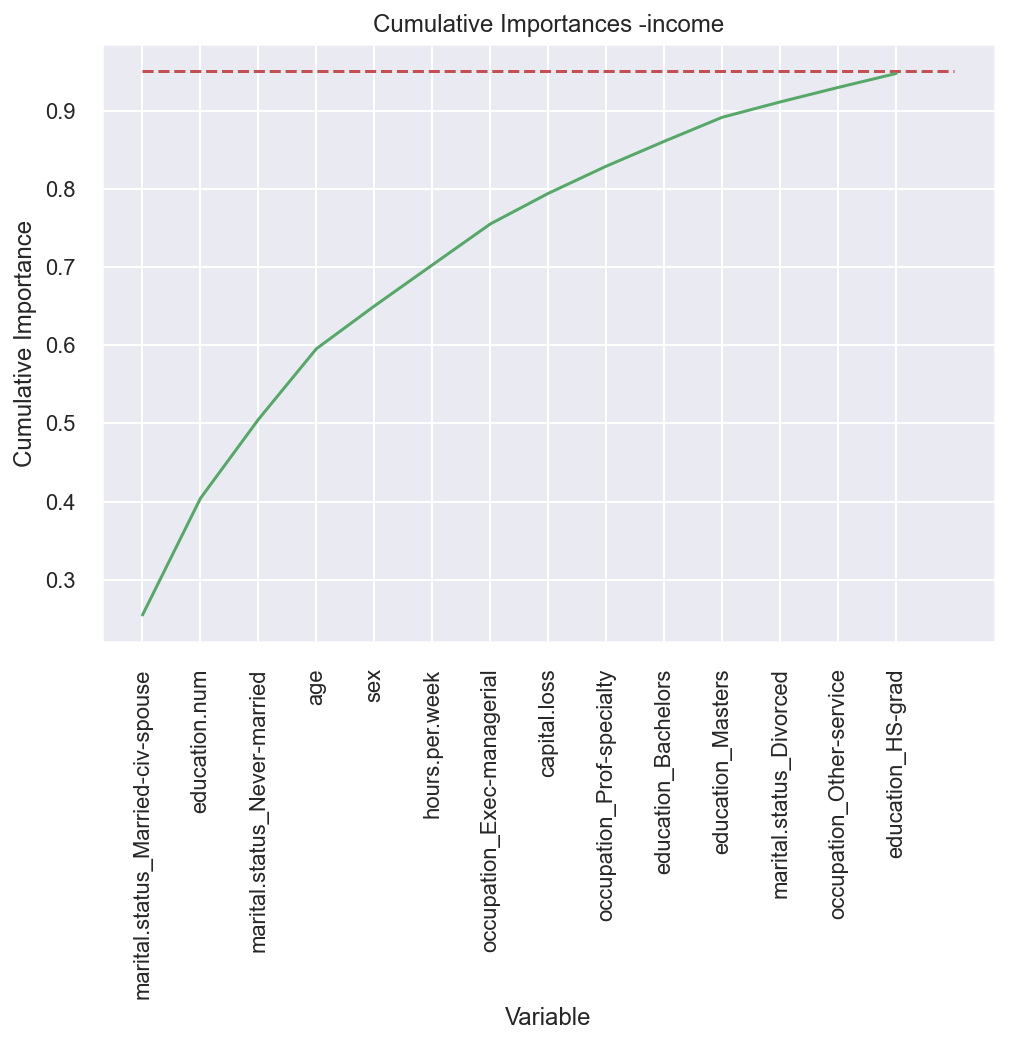

In [1156]:
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances -'+str(ds_name))
plt.show()

In [1289]:
[i[0:15] for i in sorted_features]

['marital.status_',
 'education.num',
 'marital.status_',
 'age',
 'sex',
 'hours.per.week',
 'occupation_Exec',
 'capital.loss',
 'occupation_Prof',
 'education_Bache',
 'education_Maste',
 'marital.status_',
 'occupation_Othe',
 'education_HS-gr']

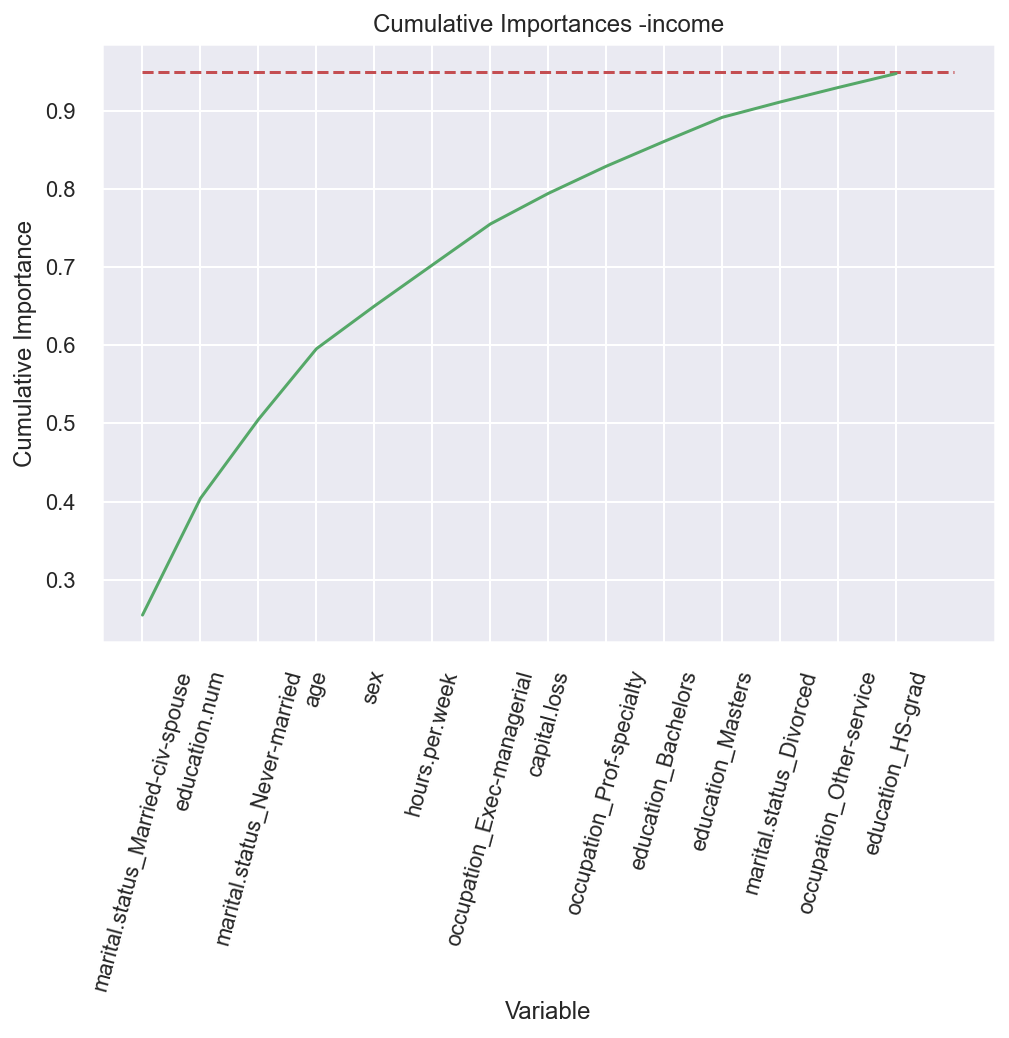

In [1288]:
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 75)
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances -'+str(ds_name))
plt.show()

# Part 3: 
## Dimensionality reduction plus Clustering

Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it.

Compare to part 1 where you also did clustering. We need to see if anything changed. Dimensionality reduction should help us find the useful information in our dataset. See if it’s doing a good job.



### PCA - Kmeans

In [554]:
component_counts = [1, 2, 10, 20, 30]
total_res = []
for n_comp in component_counts:

    pca = PCA(n_components=n_comp, random_state=42)
    x_tran = pca.fit_transform(X)
    for n_clust in n_clusters:
        kmeans = KMeans(n_clusters=n_clust,random_state=42)
        kmeans.fit(x_tran)

        y_kmeans = kmeans.predict(x_tran)
        distortion = kmeans.inertia_

        sil_score = silhouette_score(x_tran, y_kmeans, random_state=42)
        ami_score = ami(y, y_kmeans)
        total_res.append([n_comp,n_clust,sil_score,ami_score,distortion] )

In [555]:
df_pca_kmeans = pd.DataFrame.from_records(total_res,columns =['n_components','n_clusters', 'silhouette_score', 'ami_score', 'distortion'])

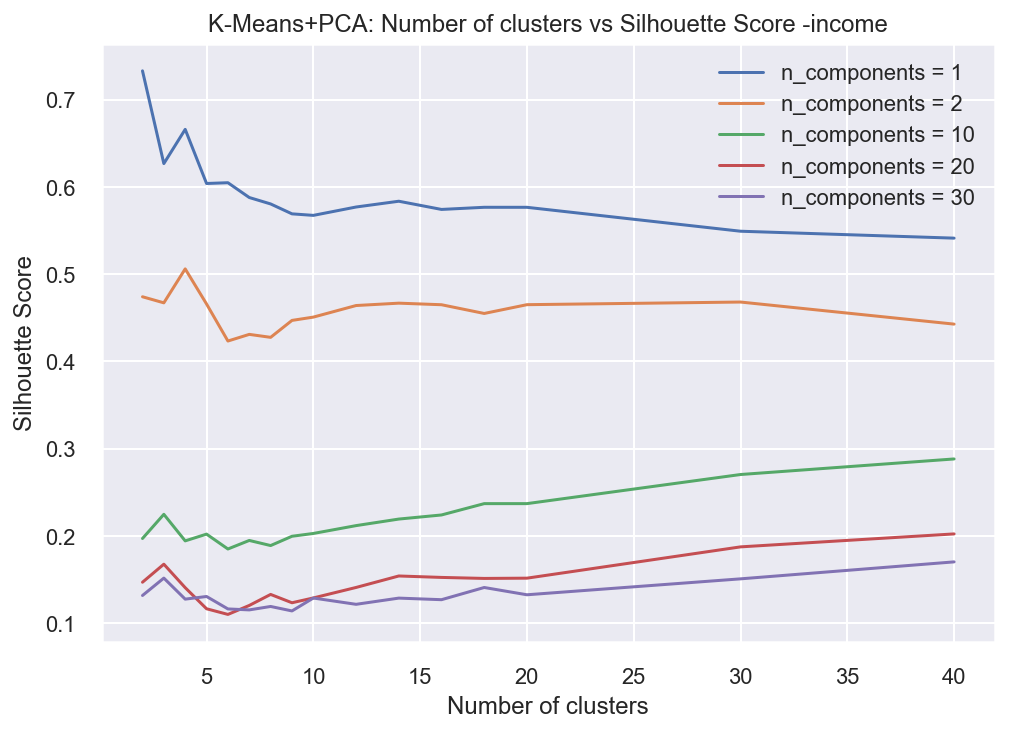

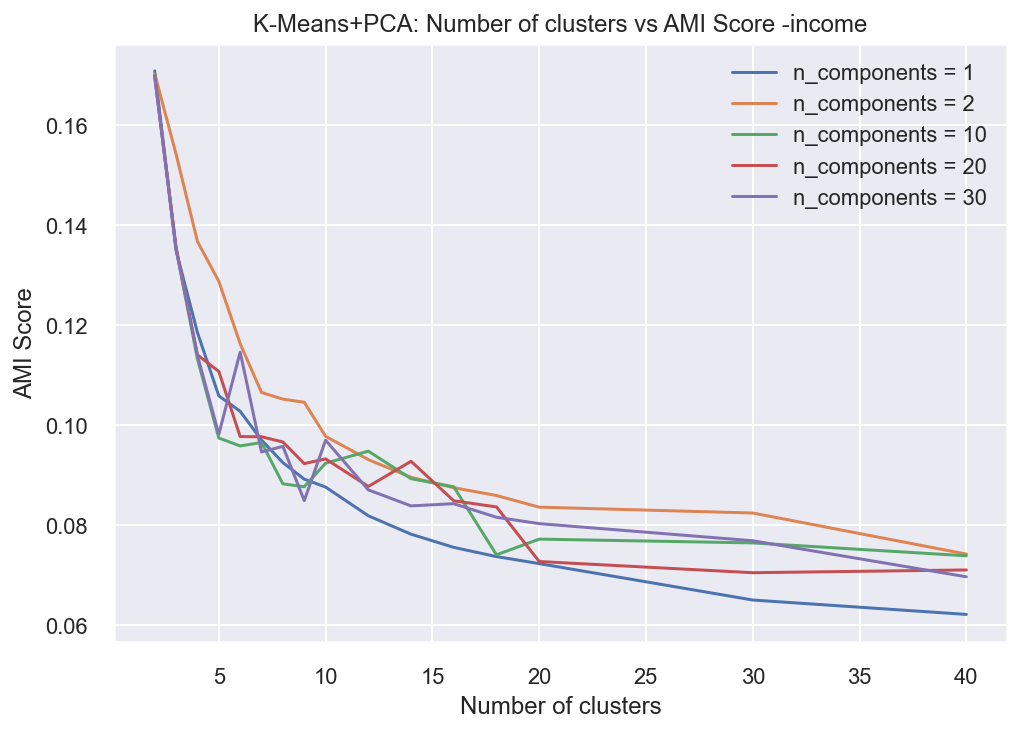

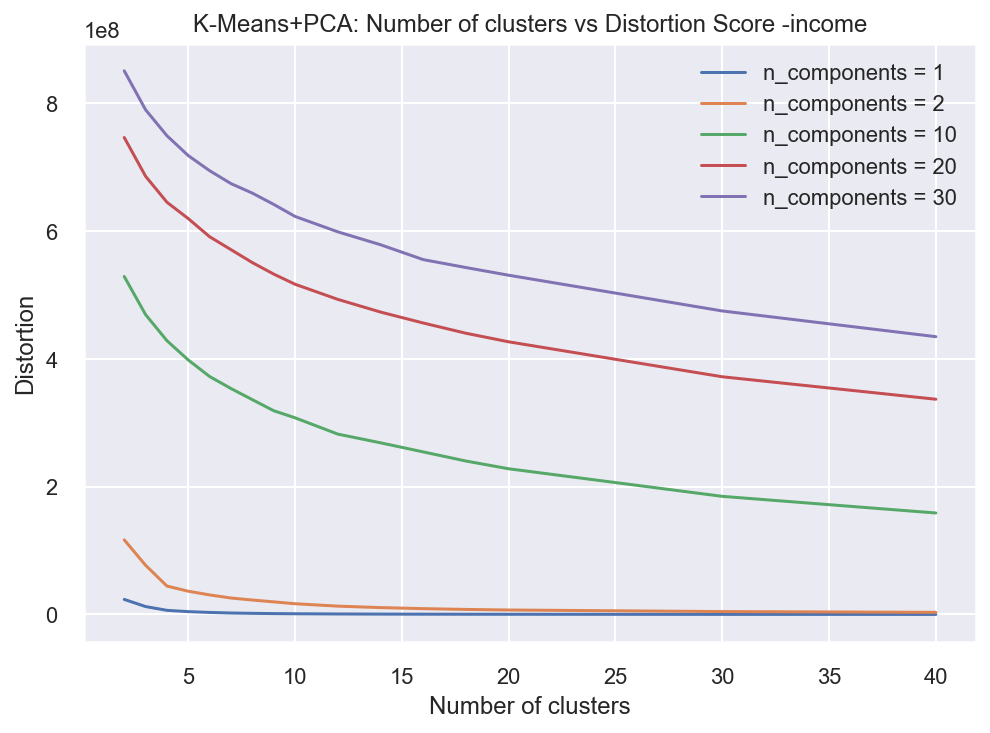

In [1157]:
plt.figure()
for n in df_pca_kmeans['n_components'].unique():
    tmp_df = df_pca_kmeans[df_pca_kmeans['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.legend()
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('K-Means+PCA: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_pca_kmeans['n_components'].unique():
    tmp_df = df_pca_kmeans[df_pca_kmeans['n_components'] == n][['n_clusters', 'ami_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('AMI Score')
    plt.legend()
    plt.title('K-Means+PCA: Number of clusters vs AMI Score -'+str(ds_name))
    
plt.figure()
for n in df_pca_kmeans['n_components'].unique():
    tmp_df = df_pca_kmeans[df_pca_kmeans['n_components'] == n][['n_clusters', 'distortion']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()
    plt.title('K-Means+PCA: Number of clusters vs Distortion Score -'+str(ds_name));

## ICA - Kmeans

In [567]:
component_counts = [1, 2, 10, 20, 30]
total_res1 = []
for n_comp in component_counts:

    ica = FastICA(n_components=n_comp, random_state=42)
    x_tran = ica.fit_transform(X)
    
    for n_clust in n_clusters:
        kmeans = KMeans(n_clusters=n_clust,random_state=42)
        kmeans.fit(x_tran)

        y_kmeans = kmeans.predict(x_tran)
        distortion = kmeans.inertia_
        total_kurtosis = np.abs(kurtosis(tmp_X_tr, axis=0)).sum()

        sil_score = silhouette_score(x_tran, y_kmeans, random_state=42)
        ami_score = ami(y, y_kmeans)
        total_res1.append([n_comp,n_clust,sil_score,ami_score,distortion] )

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [570]:
df_ica_kmeans = pd.DataFrame.from_records(total_res1,columns =['n_components','n_clusters', 'silhouette_score', 'ami_score', 'distortion'])

A higher Silhouette Coefficient score relates to a model with better defined clusters.


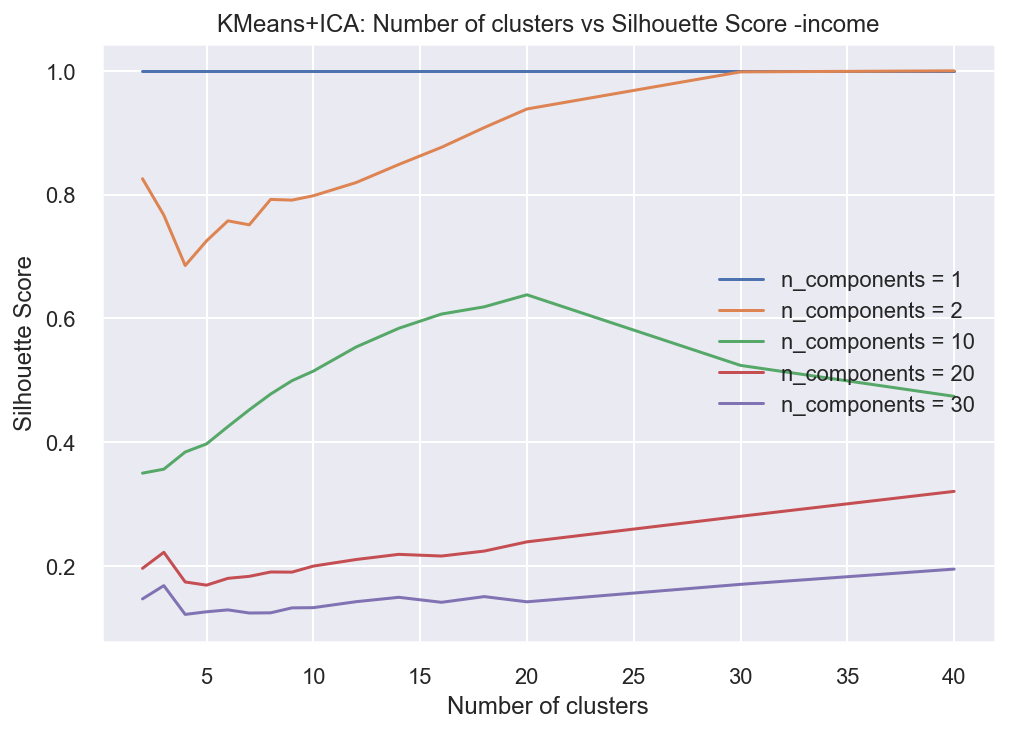

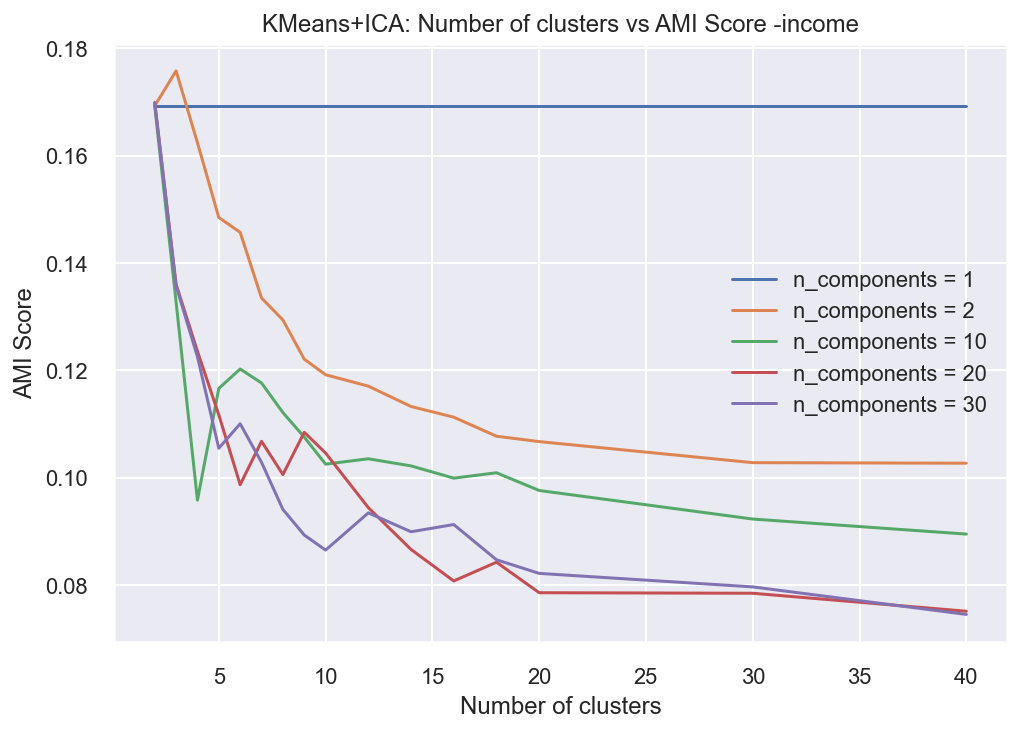

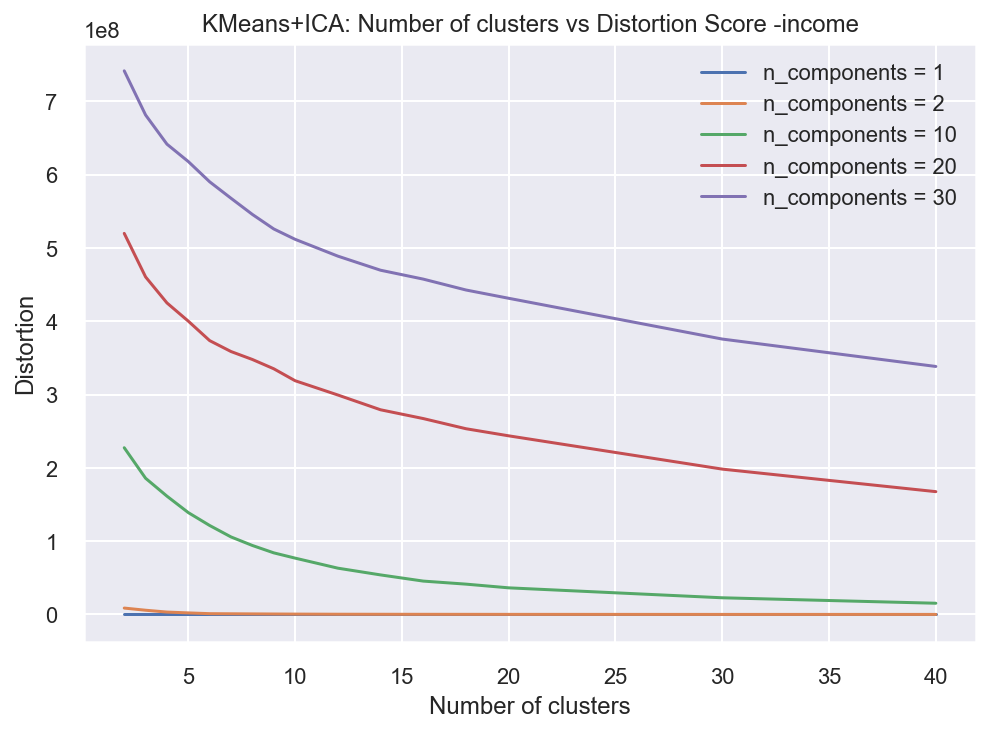

In [1158]:
plt.figure()
for n in df_ica_kmeans['n_components'].unique():
    tmp_df = df_ica_kmeans[df_ica_kmeans['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.legend()
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans+ICA: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_ica_kmeans['n_components'].unique():
    tmp_df = df_ica_kmeans[df_ica_kmeans['n_components'] == n][['n_clusters', 'ami_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('AMI Score')
    plt.legend()
    plt.title('KMeans+ICA: Number of clusters vs AMI Score -'+str(ds_name))
    
plt.figure()
for n in df_ica_kmeans['n_components'].unique():
    tmp_df = df_ica_kmeans[df_ica_kmeans['n_components'] == n][['n_clusters', 'distortion']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()
    plt.title('KMeans+ICA: Number of clusters vs Distortion Score -'+str(ds_name));

## RF - Kmeans

In [586]:
def run_RFC(X,y):
    rfc = RFC(n_estimators=200,min_samples_leaf=round(len(X)*.01),random_state=42,n_jobs=-1, max_depth=5)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=X.columns)
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=100]
    top_cols = imp.index.tolist()
    return imp, top_cols

In [587]:
imp, top_cols= run_RFC(X,y)

In [592]:
component_counts = [1, 2, 10, 20, 30]
total_res_rf1 = []
for n_comp in component_counts:

    #pca = PCA(n_components=n_comp, random_state=42)
    x_tran = X[top_cols[0:n_comp]]
    for n_clust in n_clusters:
        kmeans = KMeans(n_clusters=n_clust,random_state=42)
        kmeans.fit(x_tran)

        y_kmeans = kmeans.predict(x_tran)
        distortion = kmeans.inertia_

        sil_score = silhouette_score(x_tran, y_kmeans, random_state=42)
        ami_score = ami(y, y_kmeans)
        total_res_rf1.append([n_comp,n_clust,sil_score,ami_score,distortion] )

<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(x_tran)
<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans.fit(x_tran)
<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(x_tran)
<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans.fit(x_tran)
<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(x_tran)
<ipython-input-592-eb017bd57c1e>:9: ConvergenceWarning: Number of distinct clusters (

In [868]:
df_rf_kmeans = pd.DataFrame.from_records(total_res_rf1,columns =['n_components','n_clusters', 'silhouette_score', 'ami_score', 'distortion'])

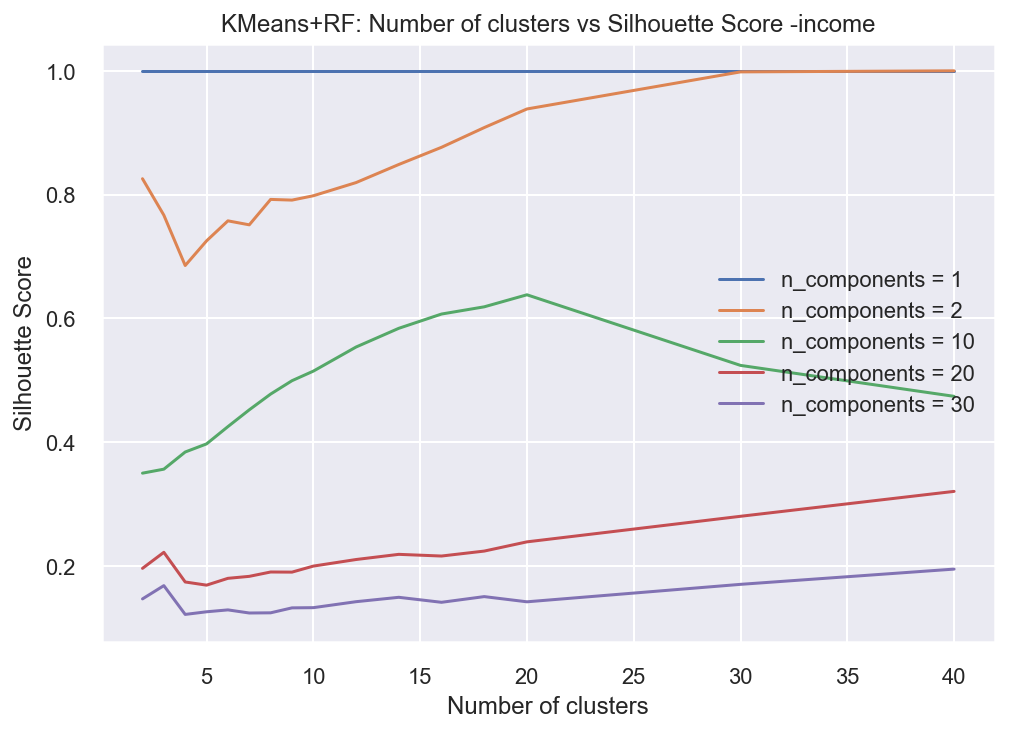

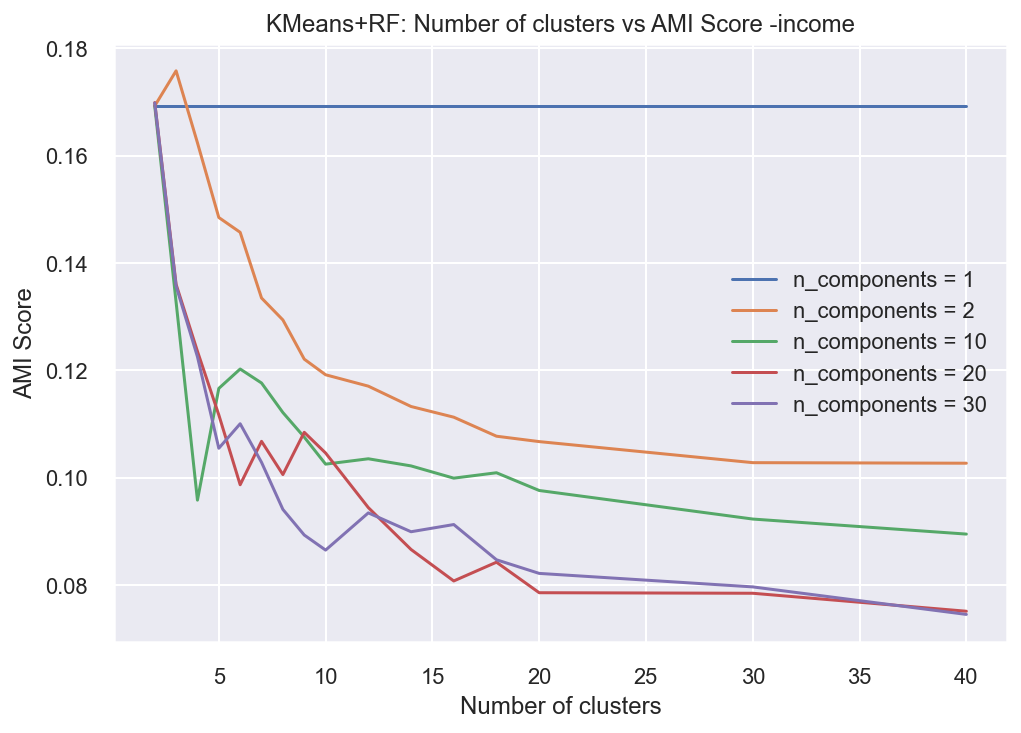

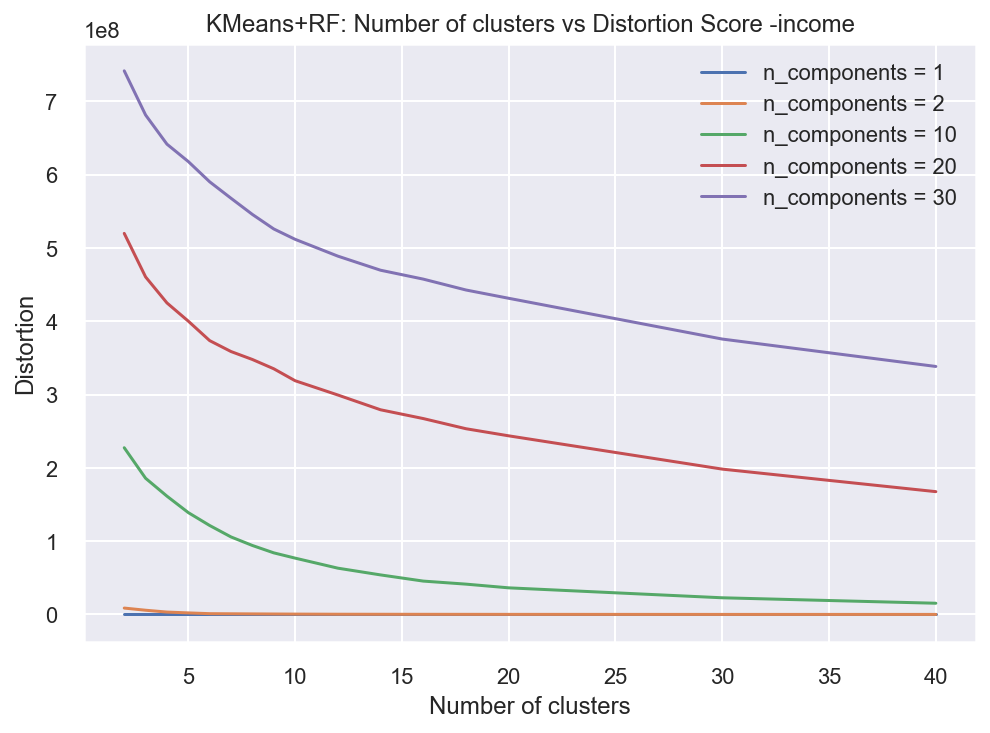

In [1159]:
plt.figure()
for n in df_rf_kmeans['n_components'].unique():
    tmp_df = df_rf_kmeans[df_rf_kmeans['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.legend()
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans+RF: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_rf_kmeans['n_components'].unique():
    tmp_df = df_rf_kmeans[df_rf_kmeans['n_components'] == n][['n_clusters', 'ami_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('AMI Score')
    plt.legend()
    plt.title('KMeans+RF: Number of clusters vs AMI Score -'+str(ds_name))
    
plt.figure()
for n in df_rf_kmeans['n_components'].unique():
    tmp_df = df_rf_kmeans[df_rf_kmeans['n_components'] == n][['n_clusters', 'distortion']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()
    plt.title('KMeans+RF: Number of clusters vs Distortion Score -'+str(ds_name));

### Visualize RF+Kmeans

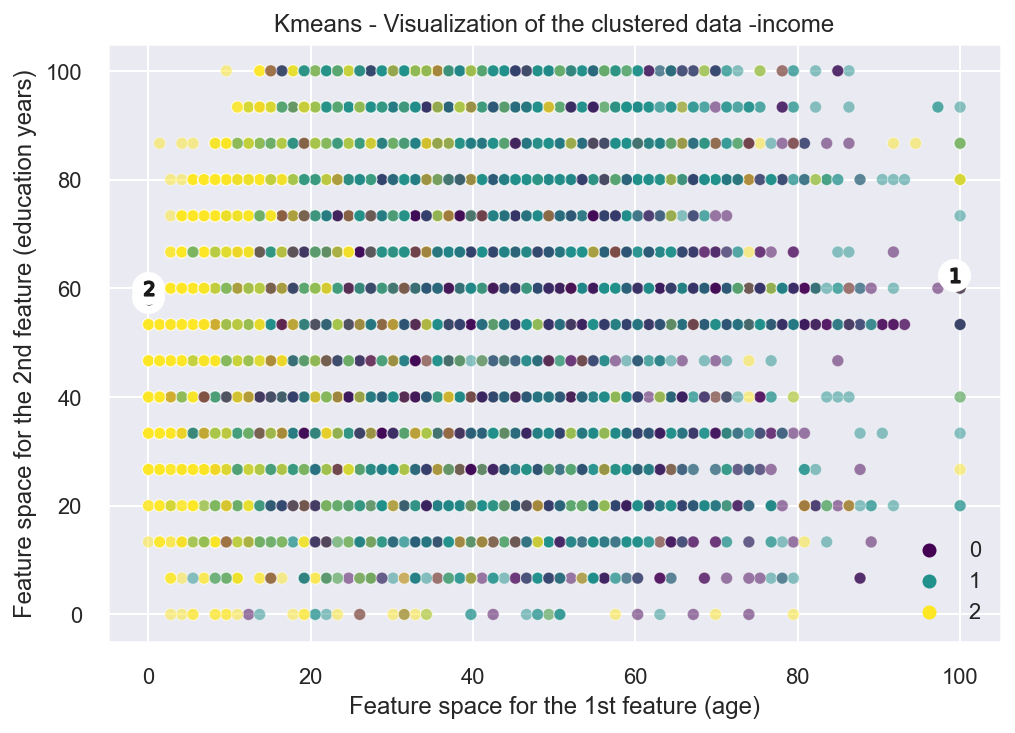

In [1160]:
rf_x = X[importance.index]

kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(rf_x)

y_kmeans_rf = kmeans.predict(rf_x)

centers = kmeans.cluster_centers_

sns.scatterplot(x =rf_x['age'], y= rf_x['education.num'], hue=y_kmeans_rf, palette='viridis', alpha=0.5,legend='full')
#plt.scatter(centers[0], centers[1], c='white', s=240, alpha=1, marker='o')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], c='white', s=240, alpha=1, marker='o')    
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    #plt.scatter(c[0], c[1], c='white', s=240, alpha=0.2, marker='o')


plt.title("Kmeans - Visualization of the clustered data -"+str(ds_name))
plt.xlabel("Feature space for the 1st feature (age)")
plt.ylabel("Feature space for the 2nd feature (education years)");

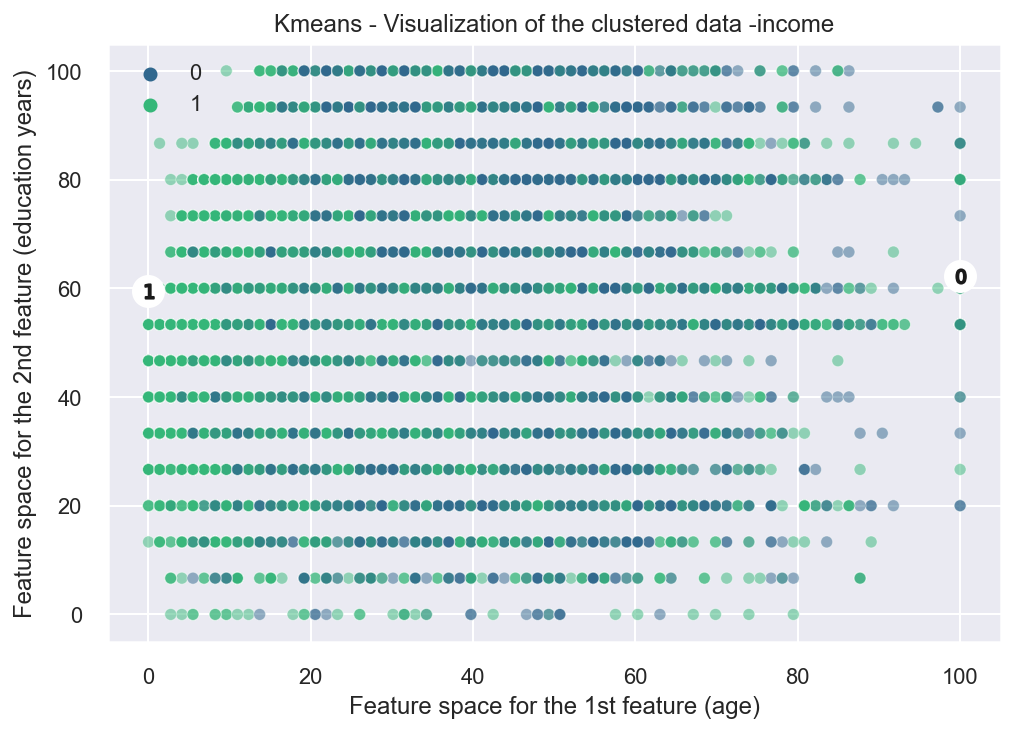

In [1294]:
rf_x = X[importance.index]

kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(rf_x)

y_kmeans_rf = kmeans.predict(rf_x)

centers = kmeans.cluster_centers_

sns.scatterplot(x =rf_x['age'], y= rf_x['education.num'], hue=y_kmeans_rf, palette='viridis', alpha=0.5,legend='full')
#plt.scatter(centers[0], centers[1], c='white', s=240, alpha=1, marker='o')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], c='white', s=240, alpha=1, marker='o')    
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    #plt.scatter(c[0], c[1], c='white', s=240, alpha=0.2, marker='o')


plt.title("Kmeans - Visualization of the clustered data -"+str(ds_name))
plt.xlabel("Feature space for the 1st feature (age)")
plt.ylabel("Feature space for the 2nd feature (education years)");

### Kmeans + RP 

In [1161]:
component_counts = [1, 2, 10, 20, 30]
total_res_rp = []
for n_comp in component_counts:

    rp = RCA(random_state=i, n_components=n_comp)
    x_tran = rp.fit_transform(X)
    
    for n_clust in n_clusters:
        kmeans = KMeans(n_clusters=n_clust,random_state=42)
        kmeans.fit(x_tran)

        y_kmeans = kmeans.predict(x_tran)
        distortion = kmeans.inertia_

        sil_score = silhouette_score(x_tran, y_kmeans, random_state=42)
        ami_score = ami(y, y_kmeans)
        total_res_rp.append([n_comp,n_clust,sil_score,ami_score,distortion])

KeyboardInterrupt: 

In [869]:
df_rp_kmeans = pd.DataFrame.from_records(total_res_rp,columns =['n_components','n_clusters', 'silhouette_score', 'ami_score', 'distortion'])

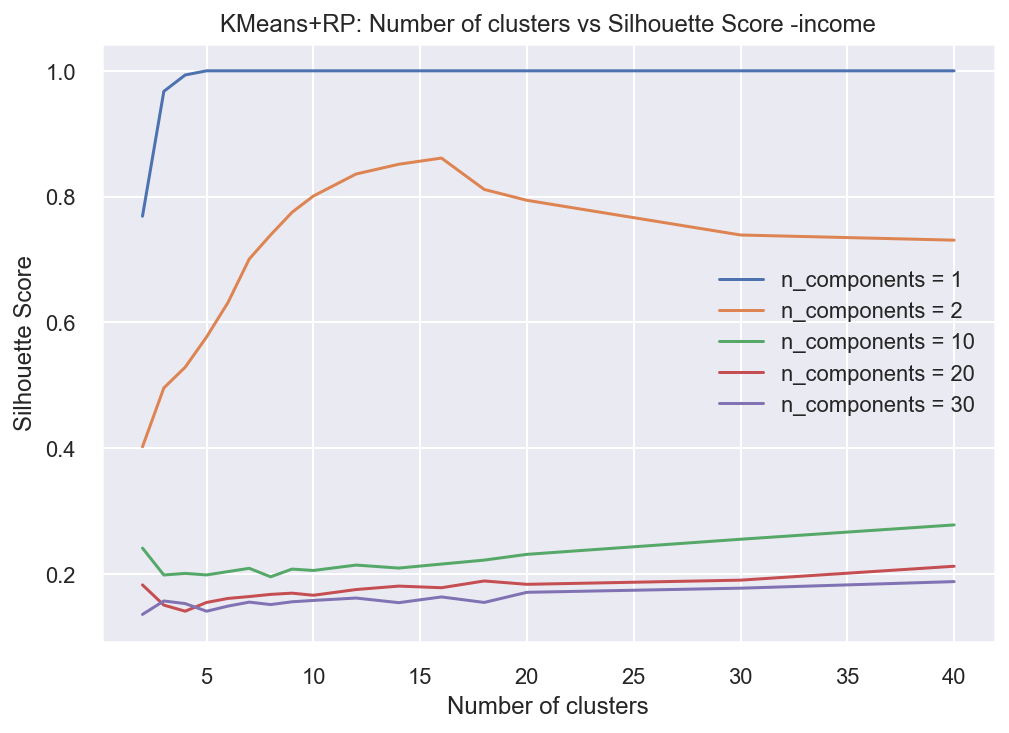

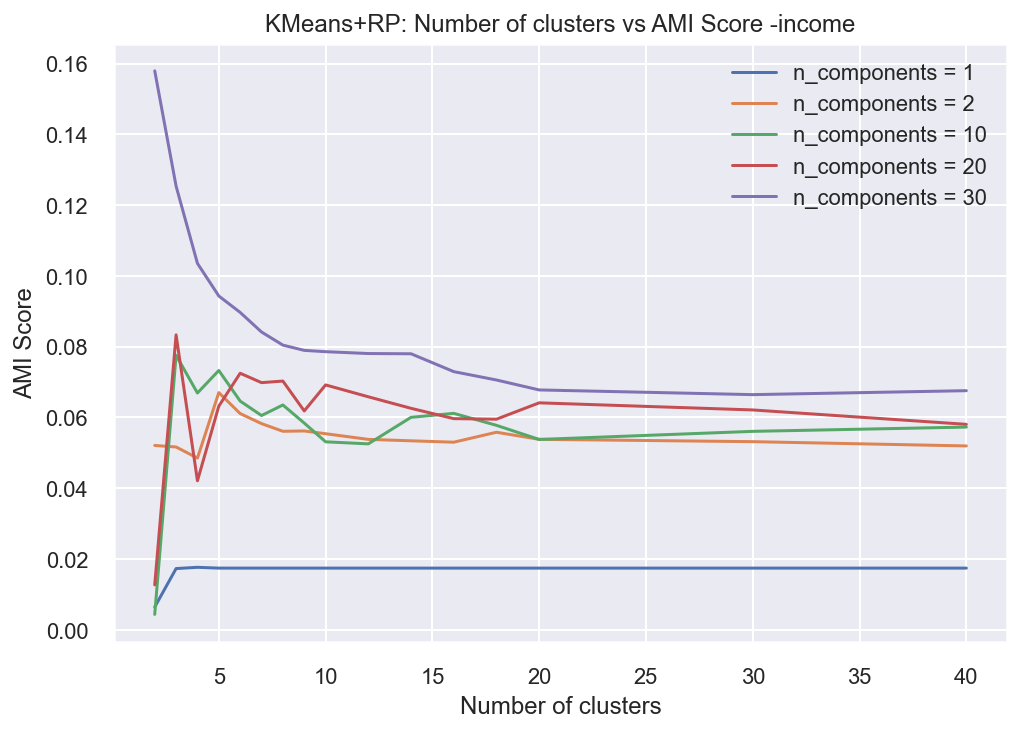

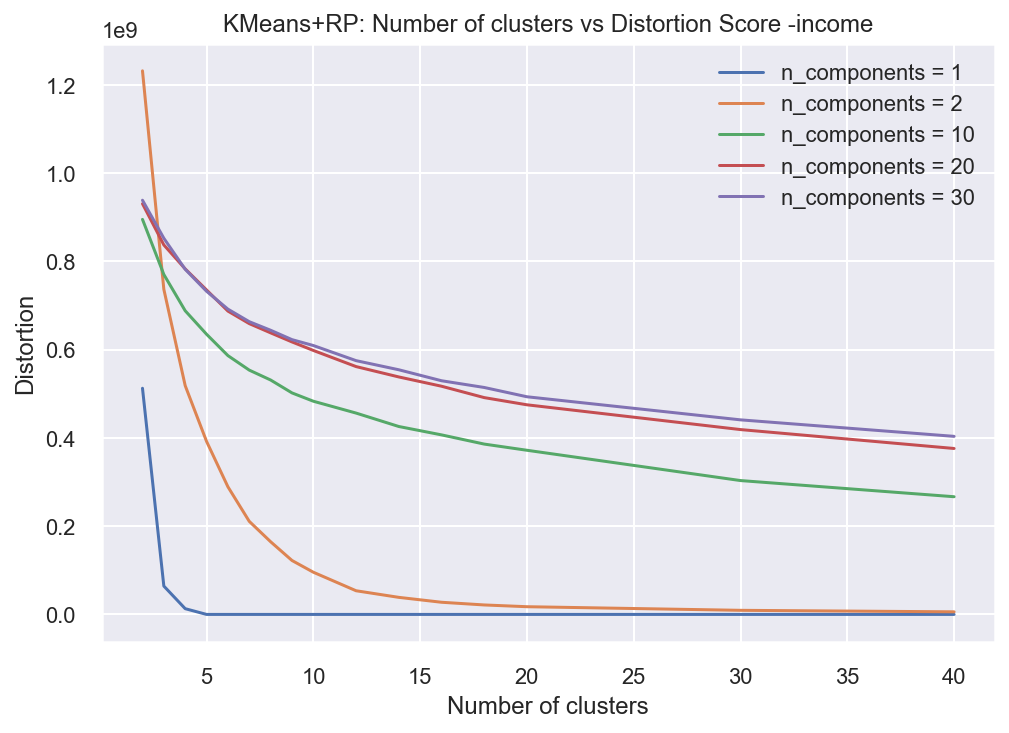

In [1162]:
plt.figure()
for n in df_rp_kmeans['n_components'].unique():
    tmp_df = df_rp_kmeans[df_rp_kmeans['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.legend()
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans+RP: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_rp_kmeans['n_components'].unique():
    tmp_df = df_rp_kmeans[df_rp_kmeans['n_components'] == n][['n_clusters', 'ami_score']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('AMI Score')
    plt.legend()
    plt.title('KMeans+RP: Number of clusters vs AMI Score -'+str(ds_name))
    
plt.figure()
for n in df_rp_kmeans['n_components'].unique():
    tmp_df = df_rp_kmeans[df_rp_kmeans['n_components'] == n][['n_clusters', 'distortion']]
    tmp_df = tmp_df.set_index('n_clusters')#.plot()
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()
    plt.title('KMeans+RP: Number of clusters vs Distortion Score -'+str(ds_name));

## EM - PCA

In [557]:
component_counts = [1, 2, 10, 20, 30]
total_res_em = []
for n_comp in tqdm(component_counts):

    pca = PCA(n_components=n_comp, random_state=0)
    x_trans = pca.fit_transform(X)
    for n_clust in n_clusters:
        gm = GaussianMixture(n_components=n_clust, random_state=42, n_init=1, init_params='kmeans')
        gm.fit(x_trans)

        y_gm = gm.predict(x_trans)
                
        bic_score = gm.bic(x_trans) 
        aic_score = gm.bic(x_trans) 
        ll_score = gm.score(x_trans)
        sil_score = silhouette_score(x_trans, y_gm, random_state=42)
        
        total_res_em.append([n_comp,n_clust,bic_score,aic_score,ll_score, sil_score])

100%|██████████| 5/5 [16:54<00:00, 202.90s/it]


In [558]:
df_pca_em = pd.DataFrame.from_records(total_res_em,columns =['n_components','n_clusters', 'bic_score', 'aic_score', 'll_score','silhouette_score'])

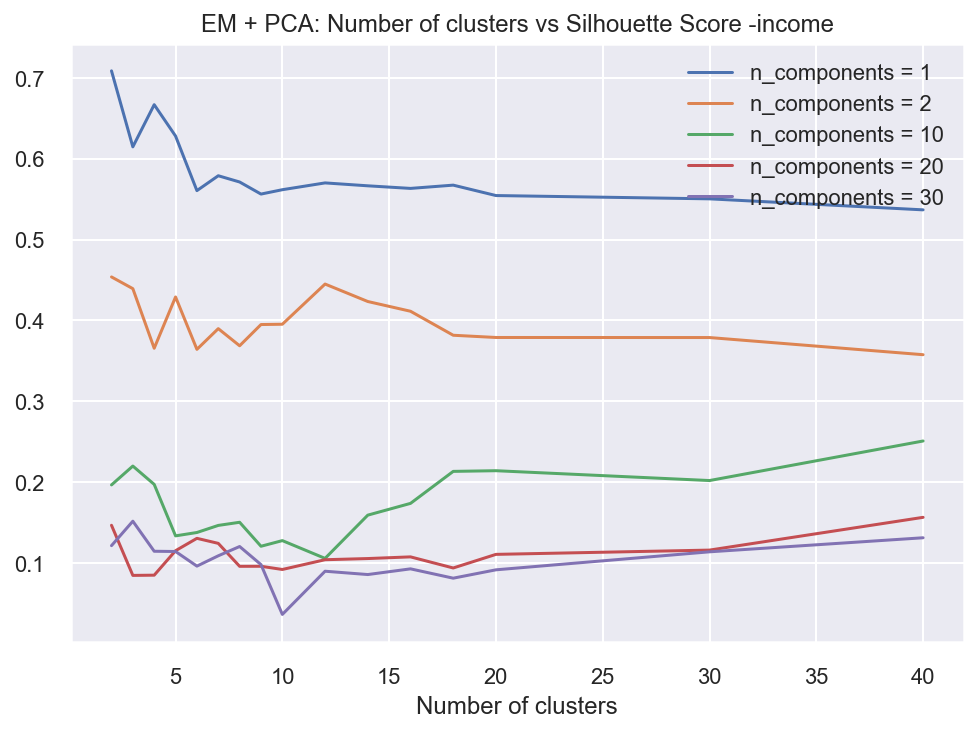

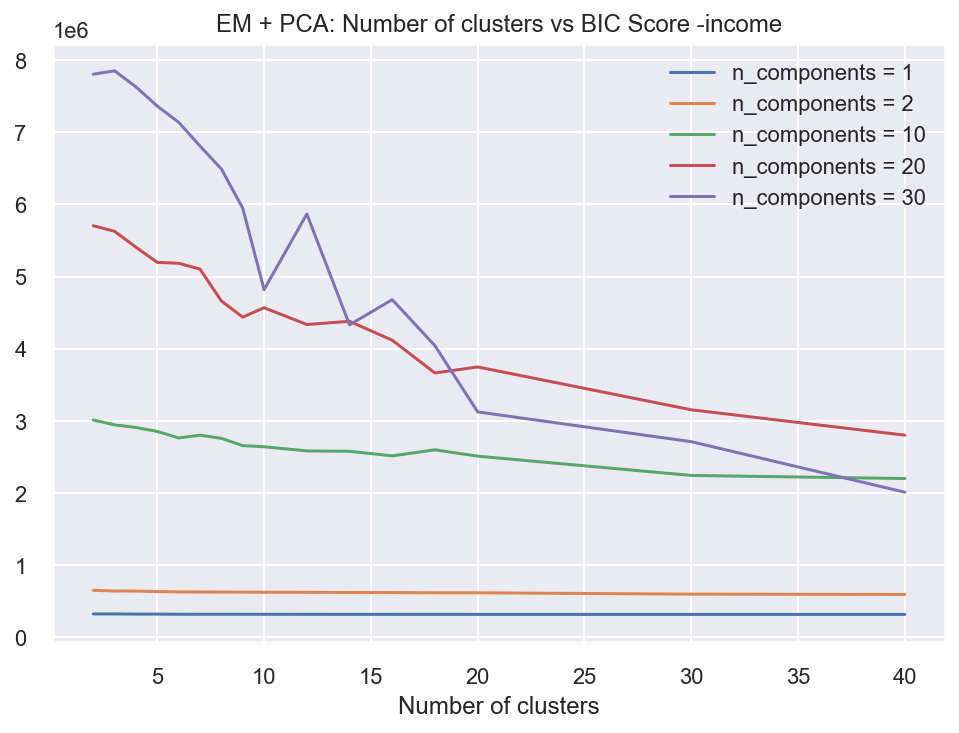

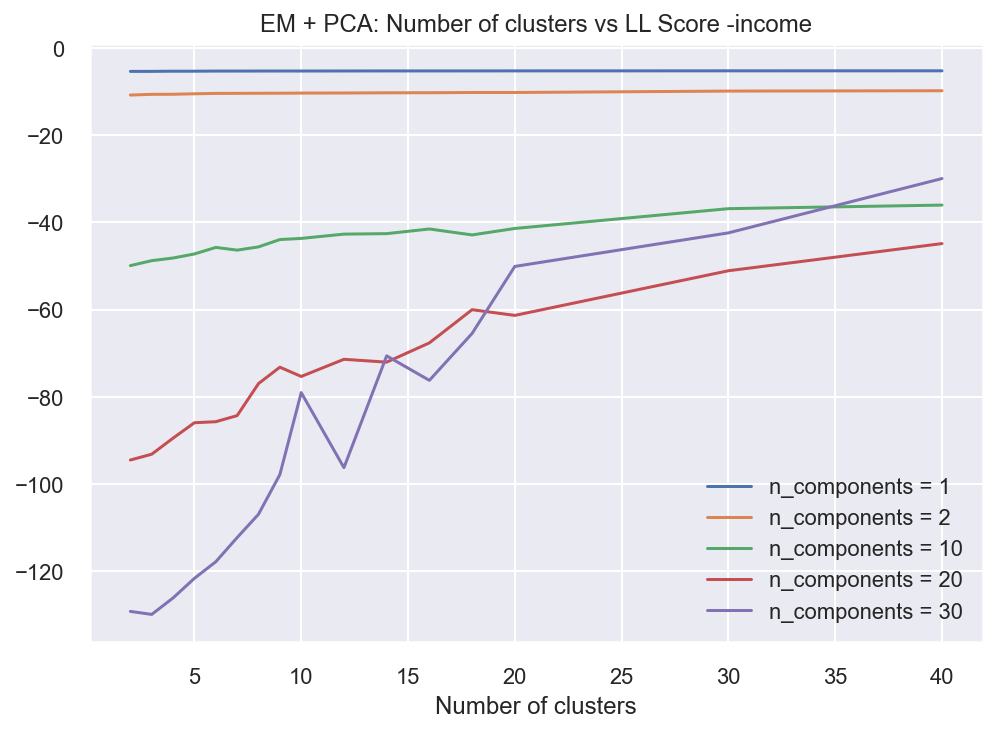

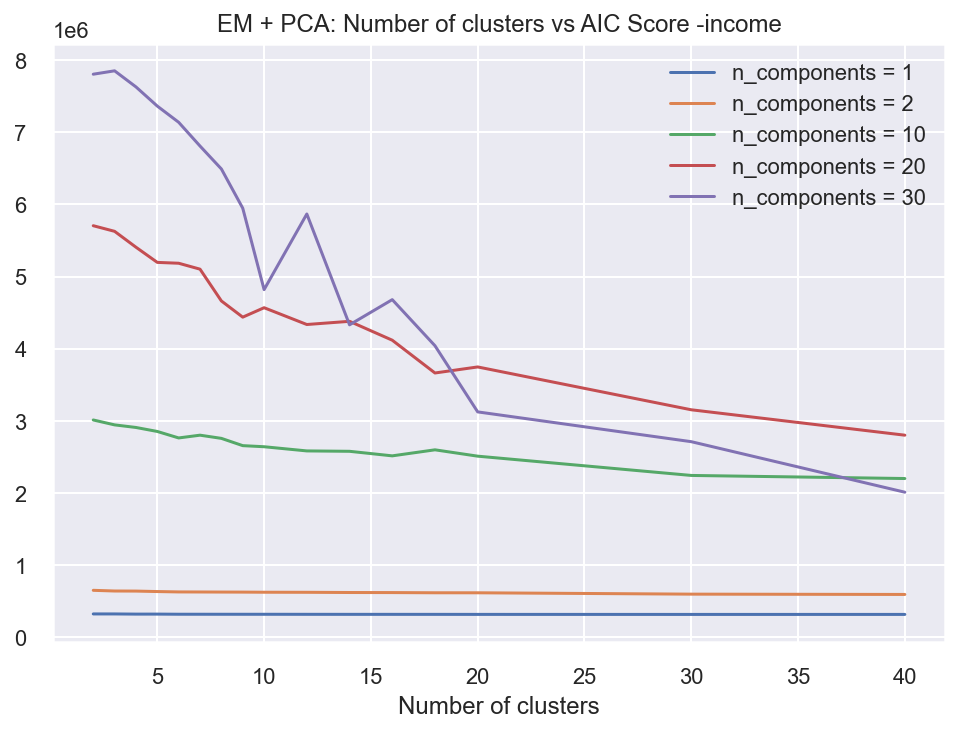

In [1163]:
plt.figure()
for n in df_pca_em['n_components'].unique():
    tmp_df = df_pca_em[df_pca_em['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + PCA: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_pca_em['n_components'].unique():
    tmp_df = df_pca_em[df_pca_em['n_components'] == n][['n_clusters', 'bic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + PCA: Number of clusters vs BIC Score -'+str(ds_name))


plt.figure()
for n in df_pca_em['n_components'].unique():
    tmp_df = df_pca_em[df_pca_em['n_components'] == n][['n_clusters', 'll_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + PCA: Number of clusters vs LL Score -'+str(ds_name))

plt.figure()
for n in df_pca_em['n_components'].unique():
    tmp_df = df_pca_em[df_pca_em['n_components'] == n][['n_clusters', 'aic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + PCA: Number of clusters vs AIC Score -'+str(ds_name));

### EM - ICA

In [993]:
component_counts = [1, 2, 10, 20, 30]
total_res_em2 = []
for n_comp in tqdm(component_counts):

    ica = FastICA(n_components=n_comp, random_state=42)

    x_trans = ica.fit_transform(X)
    for n_clust in n_clusters:
        gm = GaussianMixture(n_components=n_clust, random_state=42, n_init=1, init_params='kmeans')
        gm.fit(x_trans)

        y_gm = gm.predict(x_trans)
                
        bic_score = gm.bic(x_trans) 
        aic_score = gm.bic(x_trans) 
        ll_score = gm.score(x_trans)
        sil_score = silhouette_score(x_trans, y_gm, random_state=42)
        
        total_res_em2.append([n_comp,n_clust,bic_score,aic_score,ll_score, sil_score])

 40%|████      | 2/5 [06:31<09:42, 194.07s/it]/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
100%|██████████| 5/5 [17:24<00:00, 208.82s/it]


In [995]:
df_ica_em = pd.DataFrame.from_records(total_res_em2,columns =['n_components','n_clusters', 'bic_score', 'aic_score', 'll_score','silhouette_score'])

In [996]:
df_ica_em.groupby('n_components')['silhouette_score'].describe()

count      mean       std       min       25%       50%  \
n_components                                                            
1              18.0  0.451404  0.103880  0.316274  0.381398  0.463231   
2              18.0  0.373775  0.061019  0.262333  0.323928  0.379602   
10             18.0  0.188360  0.047233  0.081931  0.154421  0.190046   
20             18.0  0.164383  0.045925  0.067125  0.138180  0.179072   
30             18.0  0.133977  0.056221  0.039831  0.080878  0.161519   

                   75%       max  
n_components                      
1             0.480151  0.724645  
2             0.412666  0.491415  
10            0.207433  0.273509  
20            0.198156  0.227276  
30            0.174301  0.202721

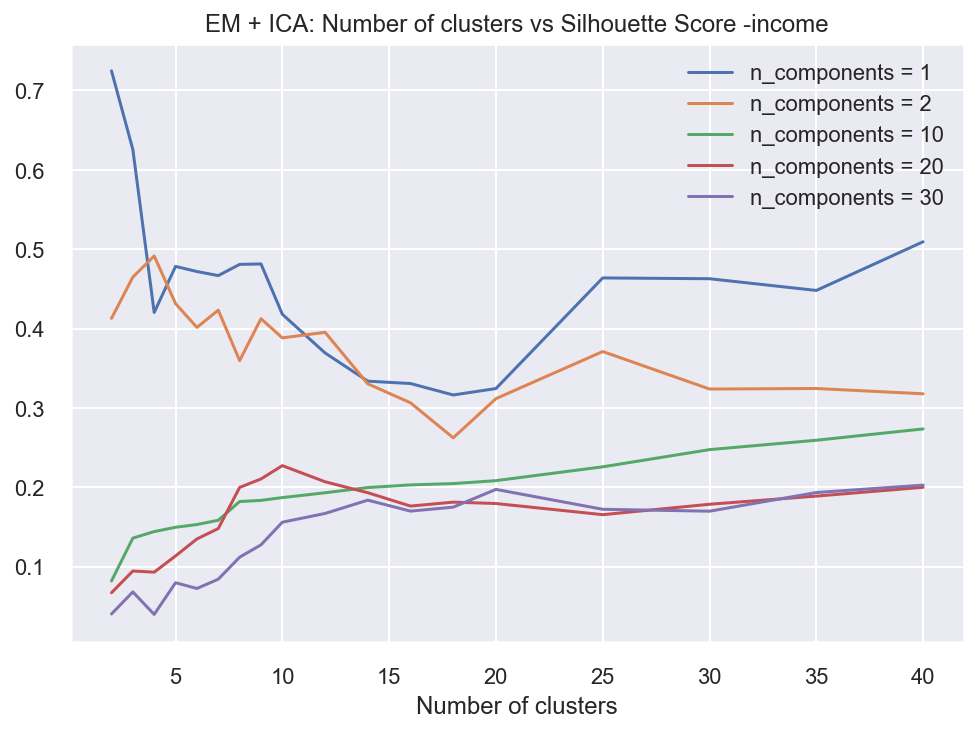

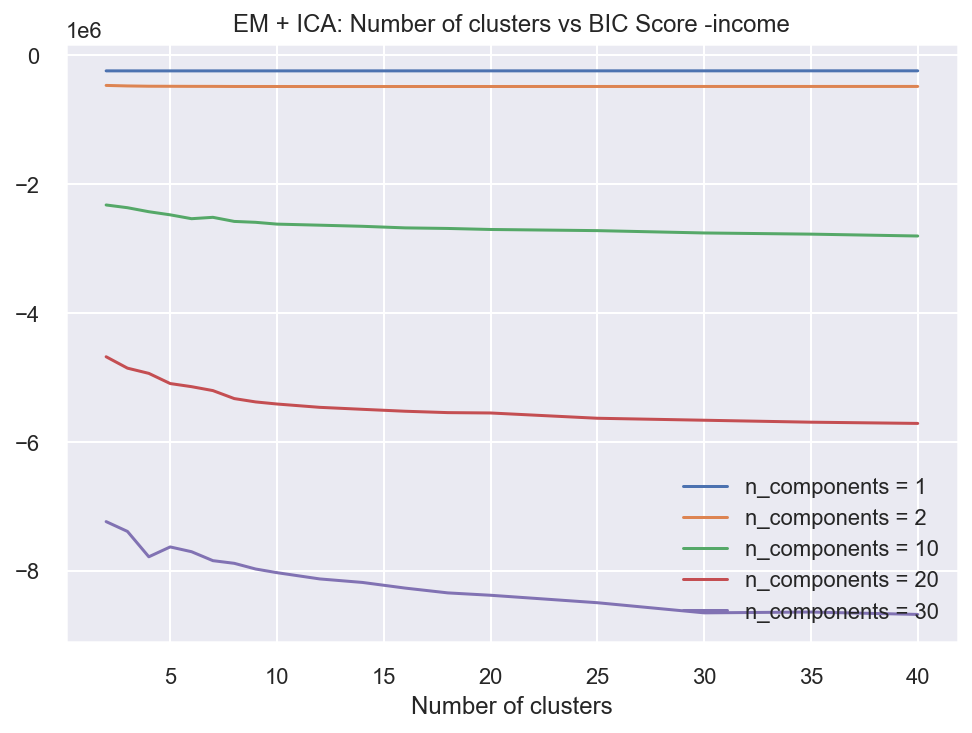

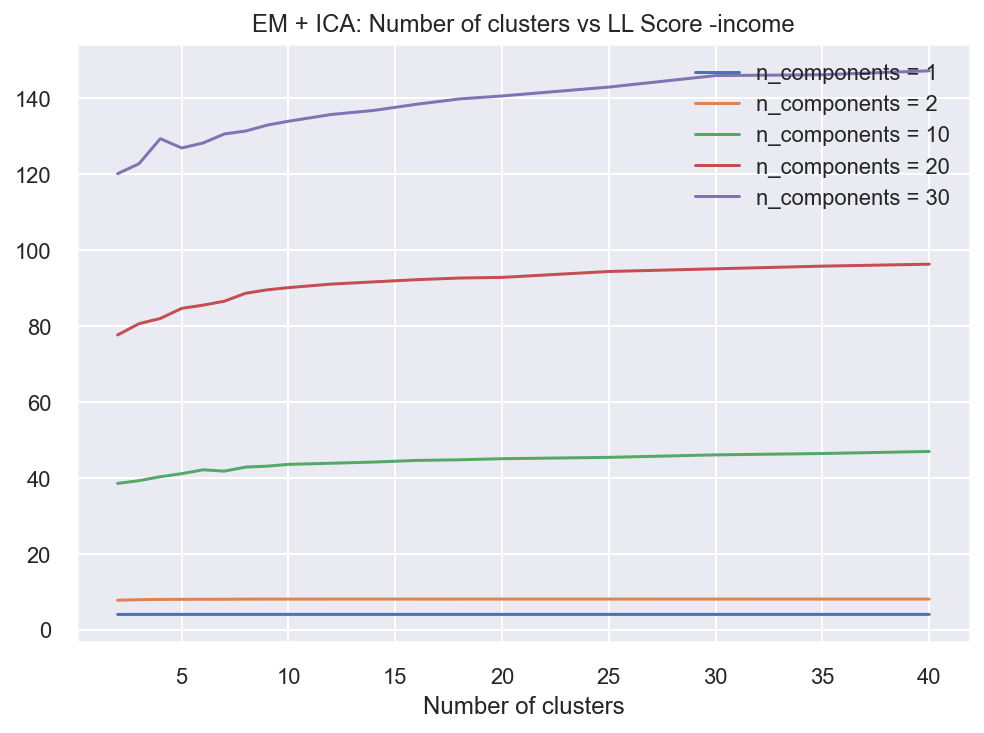

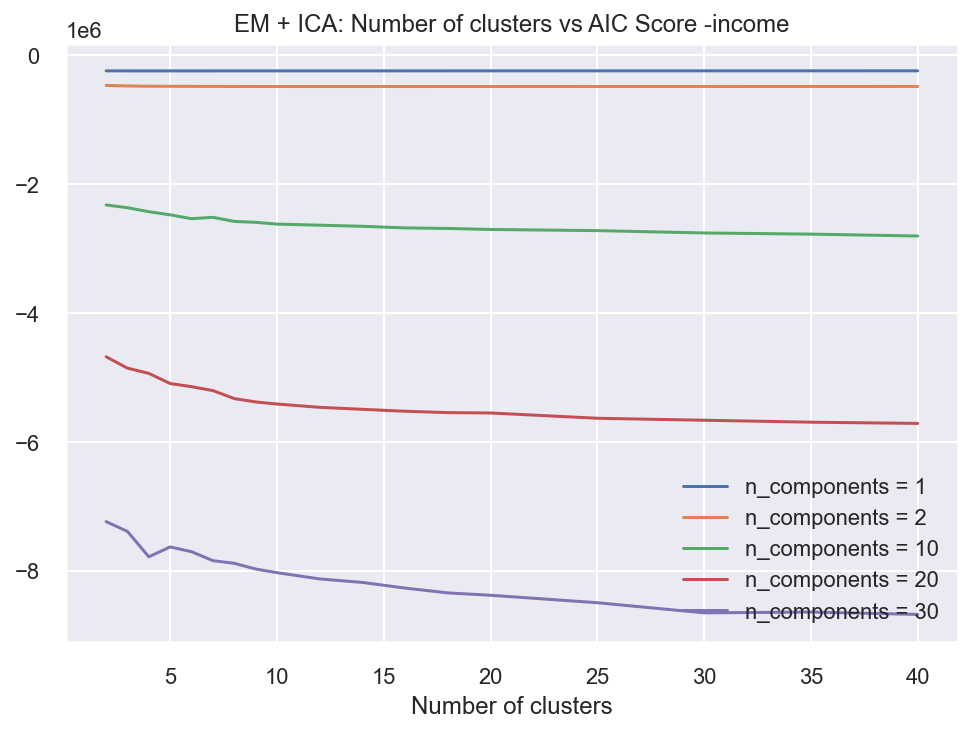

In [1164]:
plt.figure()
for n in df_ica_em['n_components'].unique():
    tmp_df = df_ica_em[df_ica_em['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + ICA: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_ica_em['n_components'].unique():
    tmp_df = df_ica_em[df_ica_em['n_components'] == n][['n_clusters', 'bic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + ICA: Number of clusters vs BIC Score -'+str(ds_name))


plt.figure()
for n in df_ica_em['n_components'].unique():
    tmp_df = df_ica_em[df_ica_em['n_components'] == n][['n_clusters', 'll_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + ICA: Number of clusters vs LL Score -'+str(ds_name))

plt.figure()
for n in df_ica_em['n_components'].unique():
    tmp_df = df_ica_em[df_ica_em['n_components'] == n][['n_clusters', 'aic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + ICA: Number of clusters vs AIC Score -'+str(ds_name));

### EM - RF 

In [599]:
component_counts = [1, 2, 10, 20, 30]
total_res_em_rf = []
for n_comp in component_counts:

    x_tran = X[top_cols[0:n_comp]]
    for n_clust in n_clusters:
        gm = GaussianMixture(n_components=n_clust, random_state=42, n_init=1, init_params='kmeans')
        gm.fit(x_trans)

        y_gm = gm.predict(x_trans)
                
        bic_score = gm.bic(x_trans) 
        aic_score = gm.bic(x_trans) 
        ll_score = gm.score(x_trans)
        sil_score = silhouette_score(x_trans, y_gm, random_state=42)
        
        total_res_em_rf.append([n_comp,n_clust,bic_score,aic_score,ll_score, sil_score])

In [603]:
df_rf_em = pd.DataFrame.from_records(total_res_em_rf,columns =['n_components','n_clusters', 'bic_score', 'aic_score', 'll_score','silhouette_score'])

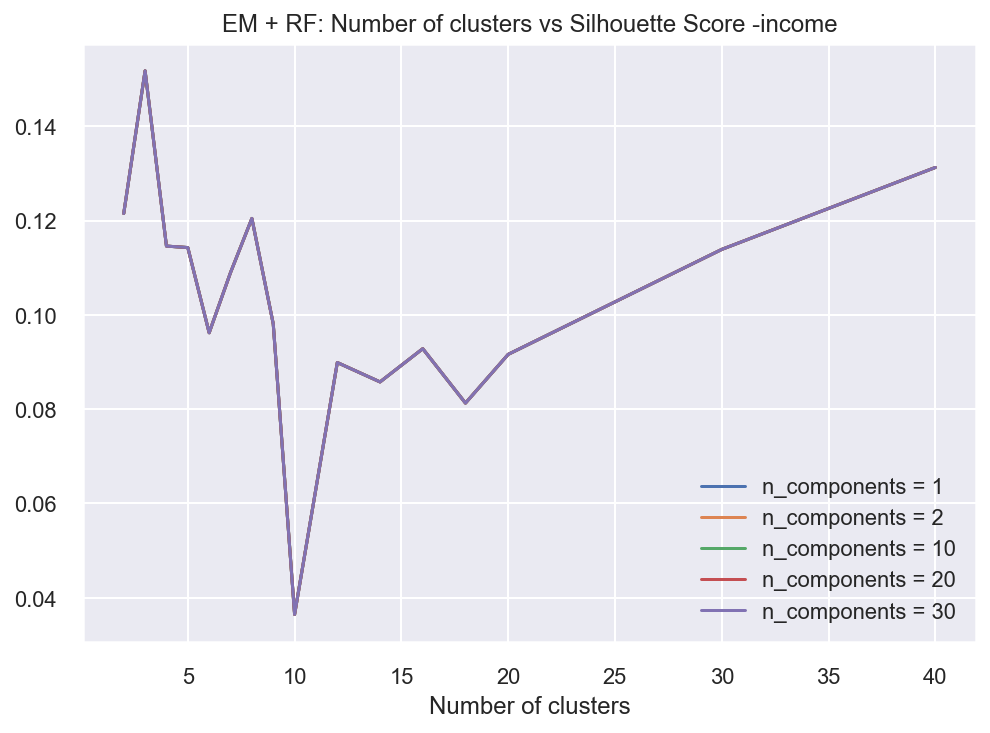

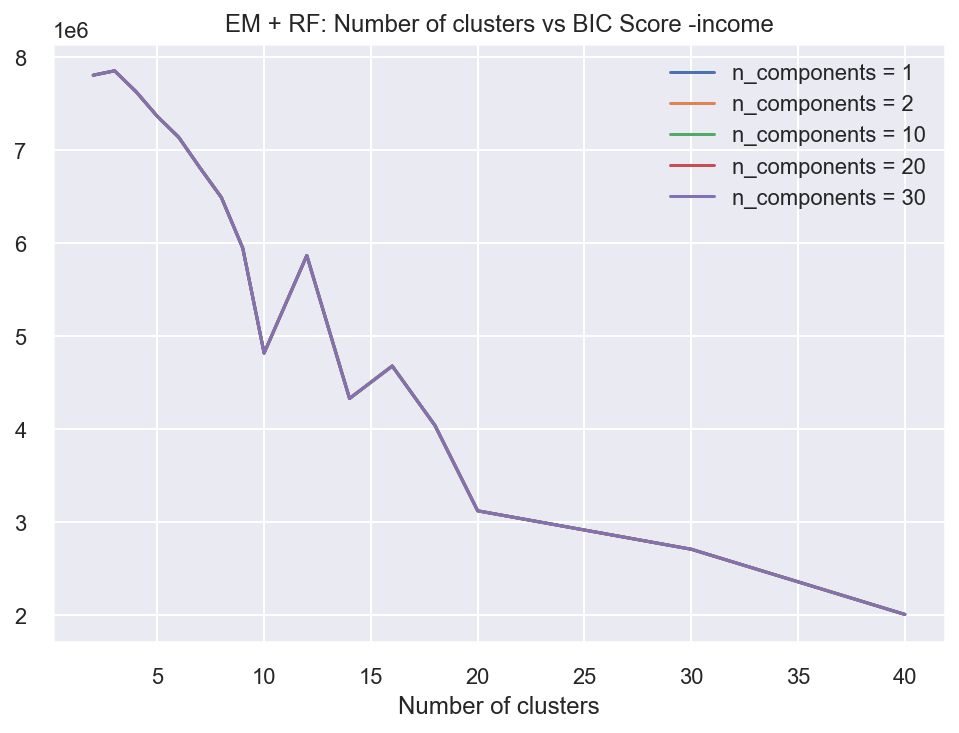

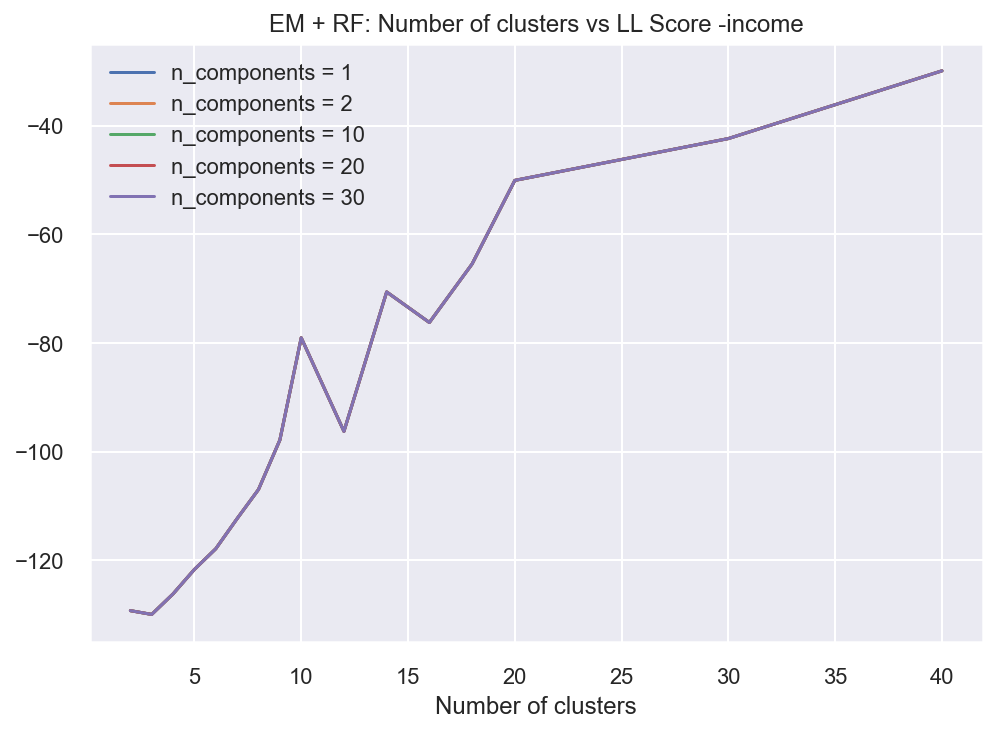

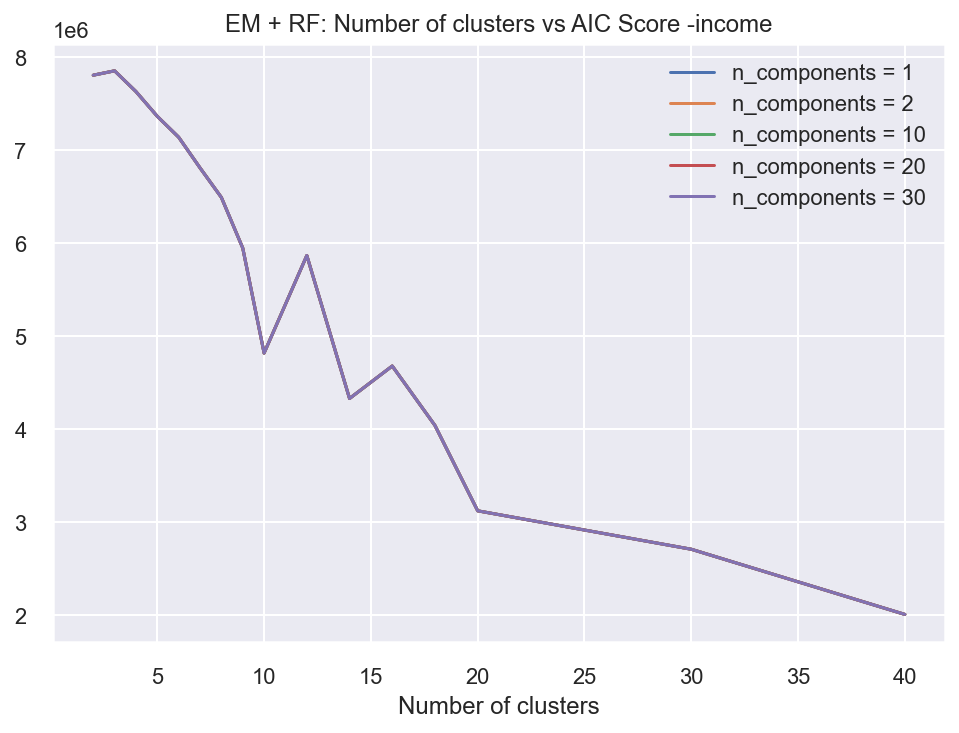

In [1165]:
plt.figure()
for n in df_rf_em['n_components'].unique():
    tmp_df = df_rf_em[df_rf_em['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RF: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_rf_em['n_components'].unique():
    tmp_df = df_rf_em[df_rf_em['n_components'] == n][['n_clusters', 'bic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RF: Number of clusters vs BIC Score -'+str(ds_name))


plt.figure()
for n in df_rf_em['n_components'].unique():
    tmp_df = df_rf_em[df_rf_em['n_components'] == n][['n_clusters', 'll_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RF: Number of clusters vs LL Score -'+str(ds_name))

plt.figure()
for n in df_rf_em['n_components'].unique():
    tmp_df = df_rf_em[df_rf_em['n_components'] == n][['n_clusters', 'aic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RF: Number of clusters vs AIC Score -'+str(ds_name));

In [873]:
component_counts = [1, 2, 10, 20, 30]
total_res_em_rp = []
for n_comp in tqdm(component_counts):

    rp = RCA(random_state=i, n_components=n_comp)


    x_trans = rp.fit_transform(X)
    for n_clust in n_clusters:
        gm = GaussianMixture(n_components=n_clust, random_state=42, n_init=1, init_params='kmeans')
        gm.fit(x_trans)

        y_gm = gm.predict(x_trans)
                
        bic_score = gm.bic(x_trans) 
        aic_score = gm.bic(x_trans) 
        ll_score = gm.score(x_trans)
        sil_score = silhouette_score(x_trans, y_gm, random_state=42)
        
        total_res_em_rp.append([n_comp,n_clust,bic_score,aic_score,ll_score, sil_score])

  0%|          | 0/5 [00:00<?, ?it/s]/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: Co

In [877]:
df_rp_em = pd.DataFrame.from_records(total_res_em_rp,columns =['n_components','n_clusters', 'bic_score', 'aic_score', 'll_score','silhouette_score'])

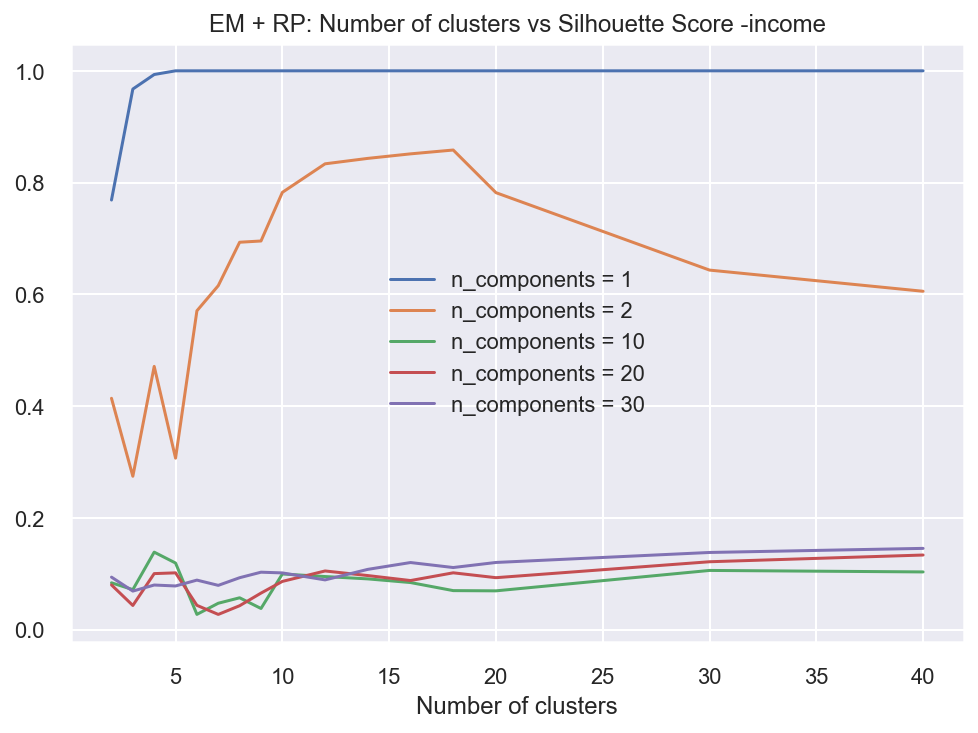

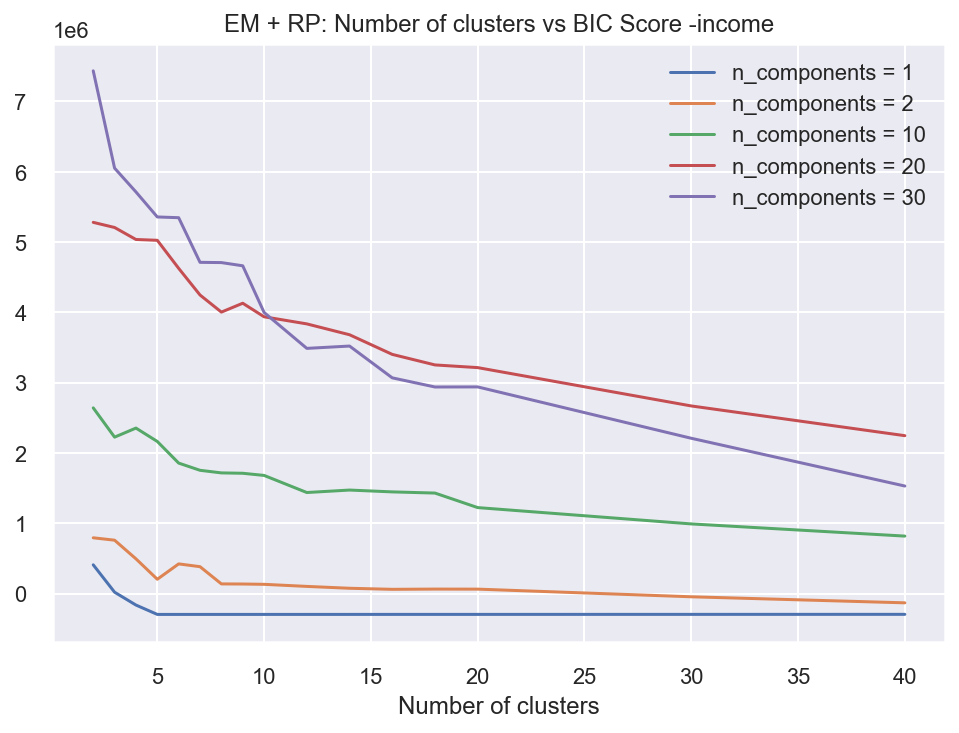

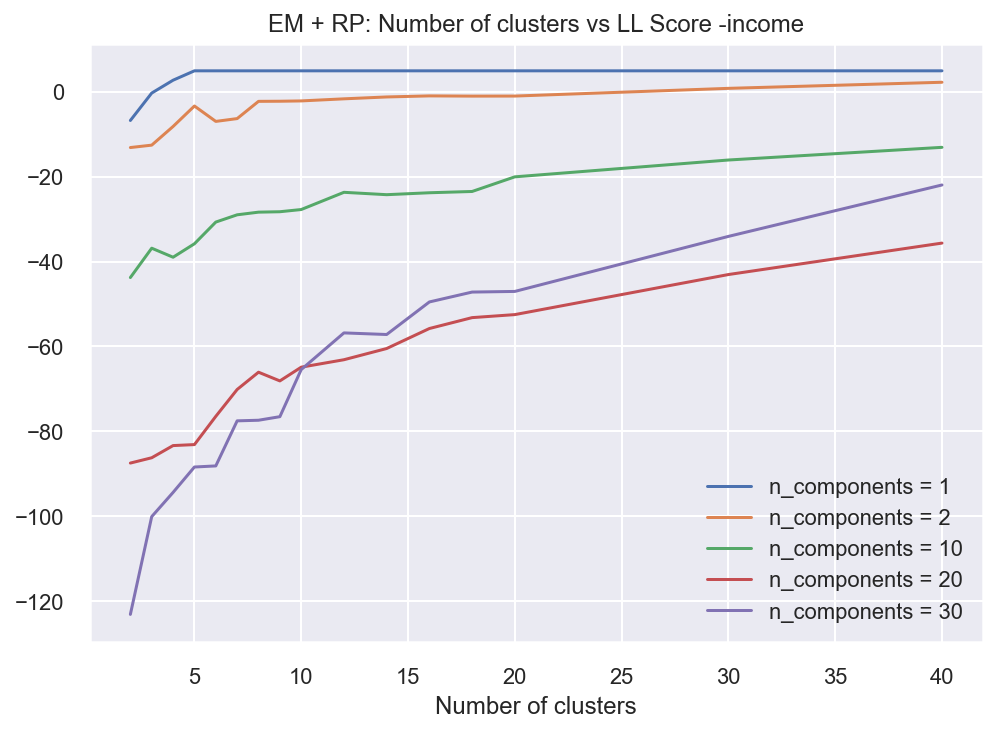

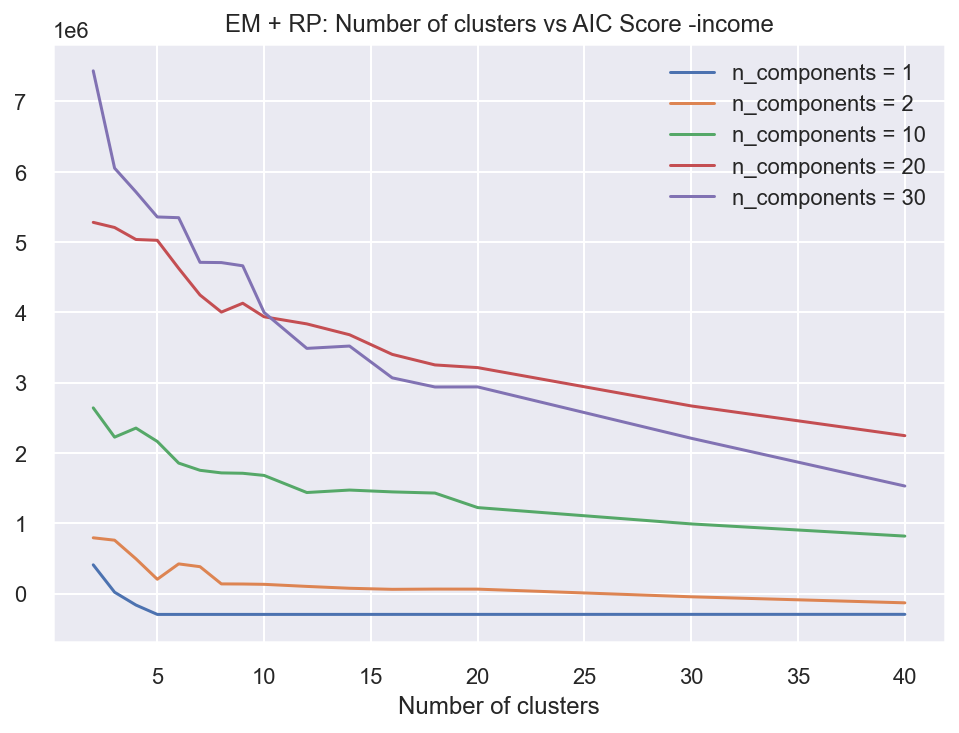

In [1166]:
plt.figure()
for n in df_rp_em['n_components'].unique():
    tmp_df = df_rp_em[df_rp_em['n_components'] == n][['n_clusters', 'silhouette_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RP: Number of clusters vs Silhouette Score -'+str(ds_name))

plt.figure()
for n in df_rp_em['n_components'].unique():
    tmp_df = df_rp_em[df_rp_em['n_components'] == n][['n_clusters', 'bic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RP: Number of clusters vs BIC Score -'+str(ds_name))


plt.figure()
for n in df_rp_em['n_components'].unique():
    tmp_df = df_rp_em[df_rp_em['n_components'] == n][['n_clusters', 'll_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RP: Number of clusters vs LL Score -'+str(ds_name))

plt.figure()
for n in df_rp_em['n_components'].unique():
    tmp_df = df_rp_em[df_rp_em['n_components'] == n][['n_clusters', 'aic_score']]
    tmp_df = tmp_df.set_index('n_clusters')
    plt.plot(tmp_df,label='n_components = '+str(n))
    plt.xlabel('Number of clusters')
    plt.legend()
plt.title('EM + RP: Number of clusters vs AIC Score -'+str(ds_name));

## Part 4

Apply the dimensionality reduction algorithms to one of your datasets from assignment #1 (if you've reused the datasets from assignment #1 to do experiments 1-3 above then you've already done this) and rerun your neural network learner on the newly projected data.

Use new features to train neural network. See if we throw away features, will it impact performance of a model like neural network. Compare with performance before dimensionality reduction. 

Pros: Throw things away - make this faster, get away of noise   
Cons: Throw information away




Switch to dataset2



In [1266]:
X = pd.read_pickle('/Users/orentevet/Notebooks/supervised_learning/X1.pkl')
#X.head(2)
y = pd.read_pickle('/Users/orentevet/Notebooks/supervised_learning/y1.pkl')
#y.head(2)

features = list(X.columns.values)

scaler = MinMaxScaler(feature_range=[0,100])
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns= features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Baseline

In [1267]:
from datetime import datetime


In [1276]:
estimator_final = MLPClassifier(hidden_layer_sizes=(128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)

t0 = datetime.now()

estimator_final.fit(X_train, y_train)
y_pred = estimator_final.predict(X_test)
t1 = datetime.now()

t_tot = t1 - t0
t_baseline = t_tot.total_seconds()
print('t=', t_tot.total_seconds())
roc_auc_score(y_test, y_pred, average='weighted')

t= 3.544236


0.7388806352396836

### PCA

In [1269]:
estimator_final = MLPClassifier(hidden_layer_sizes=(
    128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02)
estimator_final.fit(X_train, y_train)
y_pred = estimator_final.predict(X_test)

In [1270]:
import timeit

In [1272]:
list_of_n = []
roc_scores_pca,roc_scores_ica,roc_scores_rf,roc_scores_rp = [], [], [], []
t_pca, t_ica, t_rf, t_rp = [], [], [], []

for i in tqdm(range(1,25)):
    
    ## PCA ## 
    estimator_final = MLPClassifier(hidden_layer_sizes=(128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02)

    t0 = datetime.now()

    pca = PCA(n_components = i, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    estimator_final.fit(X_train_pca, y_train)
    y_pred_pca = estimator_final.predict(X_test_pca)
    t1 = datetime.now()
    t = t1 - t0 
    t_pca.append(t.total_seconds())
    
    roc_scores_pca.append(roc_auc_score(y_test, y_pred_pca, average='weighted'))
    list_of_n.append(i)

    
    ## ICA ##
    estimator_final = MLPClassifier(hidden_layer_sizes=(128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02)
    
    t0 = datetime.now()

    ica = FastICA(random_state=42,n_components=i)
    X_train_ica = ica.fit_transform(X_train)
    X_test_ica = ica.transform(X_test)
    estimator_final.fit(X_train_ica, y_train)
    y_pred_ica = estimator_final.predict(X_test_ica)
    
    t1 = datetime.now()
    t = t1 - t0 
    t_ica.append(t.total_seconds())
    roc_scores_ica.append(roc_auc_score(y_test, y_pred_ica, average='weighted'))

    ## RF ## 
    
    estimator_final = MLPClassifier(hidden_layer_sizes=(128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02)
    
    t0 = datetime.now()

    X_train_RF = X_train[top_cols[0:i]]
    X_test_RF = X_test[top_cols[0:i]]

    estimator_final.fit(X_train_RF, y_train)
    y_pred_rf = estimator_final.predict(X_test_RF)
    
    t1 = datetime.now()
    t = t1 - t0 
    t_rf.append(t.total_seconds())
    roc_scores_rf.append(roc_auc_score(y_test, y_pred_rf, average='weighted'))



    ## RP ## 
    
    estimator_final = MLPClassifier(hidden_layer_sizes=(128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02)
    
    t0 = datetime.now()
    
    rp = RCA(random_state=42, n_components=i)
    X_new = rp.fit_transform(X_train)
    X_train_rp = rp.fit_transform(X_train)
    X_test_rp = rp.transform(X_test)
    estimator_final.fit(X_train_rp, y_train)
    y_pred_rp = estimator_final.predict(X_test_rp)
    
    t1 = datetime.now()
    t = t1 - t0 
    t_rp.append(t.total_seconds())
    
    roc_scores_rp.append(roc_auc_score(y_test, y_pred_rp, average='weighted'))    

 38%|███▊      | 9/24 [01:54<03:27, 13.85s/it]/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
100%|██████████| 24/24 [05:19<00:00, 13.30s/it]


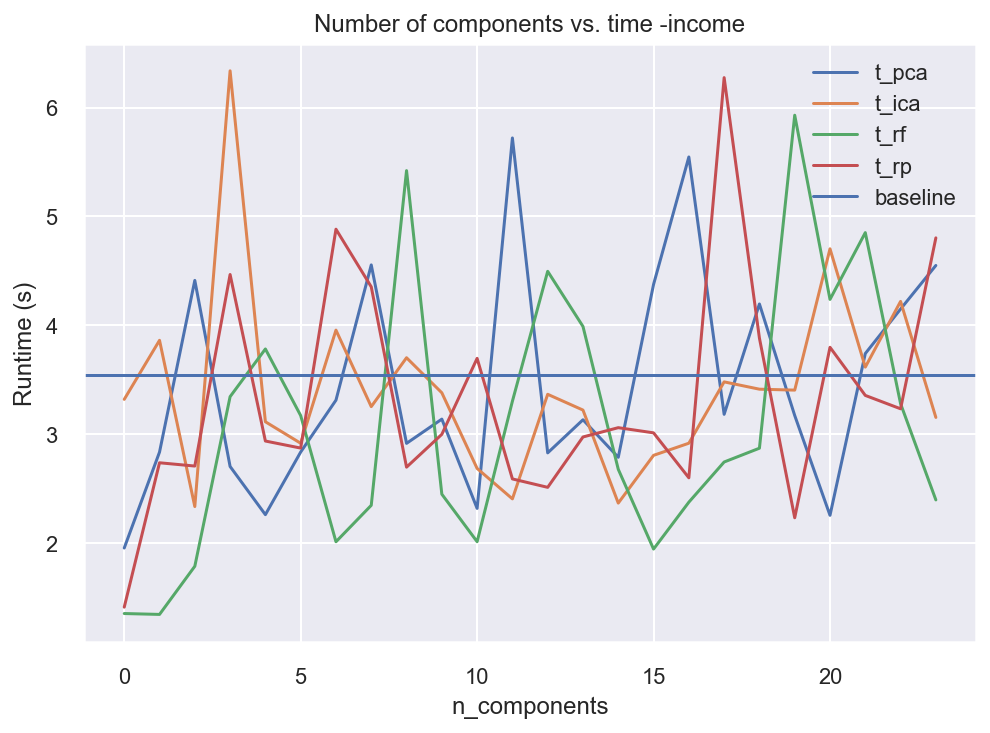

In [1279]:
nn_df_time = pd.DataFrame()
nn_df_time['n_components'] = [i for i in range(len(roc_scores_ica))]
nn_df_time['t_pca'] = t_pca
nn_df_time['t_ica'] = t_ica
nn_df_time['t_rf'] = t_rf
nn_df_time['t_rp'] = t_rp

nn_df_time.set_index('n_components', inplace=True)
nn_df_time.plot()
plt.axhline(y=t_baseline, label='baseline')
plt.title('Number of components vs. time -'+str(ds_name))
plt.ylabel('Runtime (s)')
plt.legend();

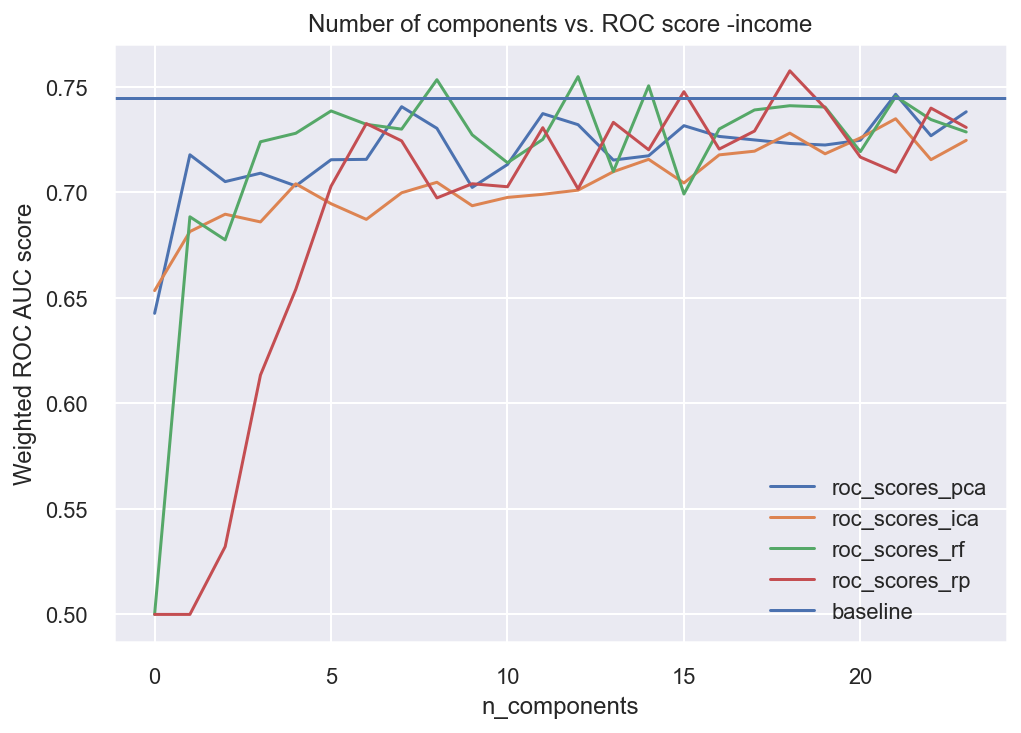

In [1273]:
nn_df = pd.DataFrame()
nn_df['n_components'] = [i for i in range(len(roc_scores_ica))]
nn_df['roc_scores_pca'] = roc_scores_pca
nn_df['roc_scores_ica'] = roc_scores_ica
nn_df['roc_scores_rf'] = roc_scores_rf
nn_df['roc_scores_rp'] = roc_scores_rp

nn_df.set_index('n_components', inplace=True)
nn_df.plot()
plt.axhline(y=roc_auc_score(y_test, y_pred, average='weighted'), label='baseline')
plt.title('Number of components vs. ROC score -'+str(ds_name))
plt.ylabel('Weighted ROC AUC score')
plt.legend();

## Part 5
 Dataset -> Clustering Algo -> NN   
 dimensionality reduction -> clustering -> NN
 
From last OH thread, you could use cluster centers, cluster labels, probabilities of one point belonging to that cluster versus another. These are a few ideas given by Prof. Isbell.
 
Do clustering + neural network. You can either: 
1. replace all features you have with clustered features
2. or add them to the features you already have. Replacement of dimensionality reduction in part 4. Treating clustering as a replacement for dimensionality reduction. 

Apply the clustering algorithms to the same dataset to which you just applied the dimensionality reduction algorithms (you've probably already done this), treating the clusters as if they were new features. In other words, treat the clustering algorithms as if they were dimensionality reduction algorithms. Again, rerun your neural network learner on the newly projected data.

Compare K-means with d.r. with normal neural network. 
We can look at k-means clusters as only features: we are kind of doing dimensionality reduction because we’ve thrown away original features and replaced with new features.
Catch: often you’ll end up with really simple features, i.e. 6 columns with one hot encoding isn’t a lot of information. So results may be same as clustering. 
We can add features as additional - not throwing away, actually adding filtered version of these features. 



In [1085]:
%%time 
km = KMeans(n_clusters=6, random_state=42)
km.fit(X)

CPU times: user 6.25 s, sys: 2.77 s, total: 9.03 s
Wall time: 649 ms


KMeans(n_clusters=6, random_state=42)

In [1086]:
#X_train_part5 =X_train.copy()
#X['km_labels'] = km.labels_
#X_test_part5 =X_test.copy()


In [1087]:
%%time 
X['km_labels'] = km.predict(X)

CPU times: user 94.4 ms, sys: 20.4 ms, total: 115 ms
Wall time: 26.1 ms


In [1089]:
estimator_final = MLPClassifier(hidden_layer_sizes=(
    128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)
#estimator_final.fit(X_train_part5, y_train)
#y_pred = estimator_final.predict(X_test_part5)
#roc_auc_score(y_test, y_pred, average='weighted')

In [1090]:
X_tmp = X.copy()
X_tmp['km_label'] = km.labels_

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


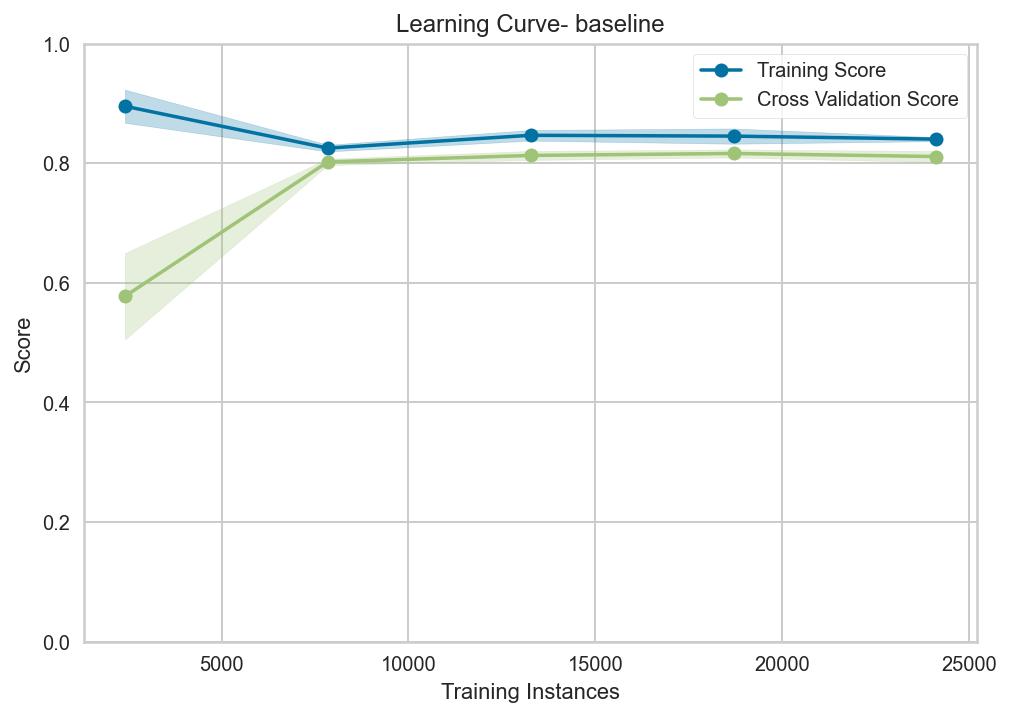

In [854]:
estimator_final = MLPClassifier(hidden_layer_sizes=(
    128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)

model = LearningCurve(estimator_final, scoring='f1_weighted', random_state =42, title= "Learning Curve- baseline")
model.fit(X, y)
model.ax.set_ylim(0,1)
model.show()

/Users/orentevet/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


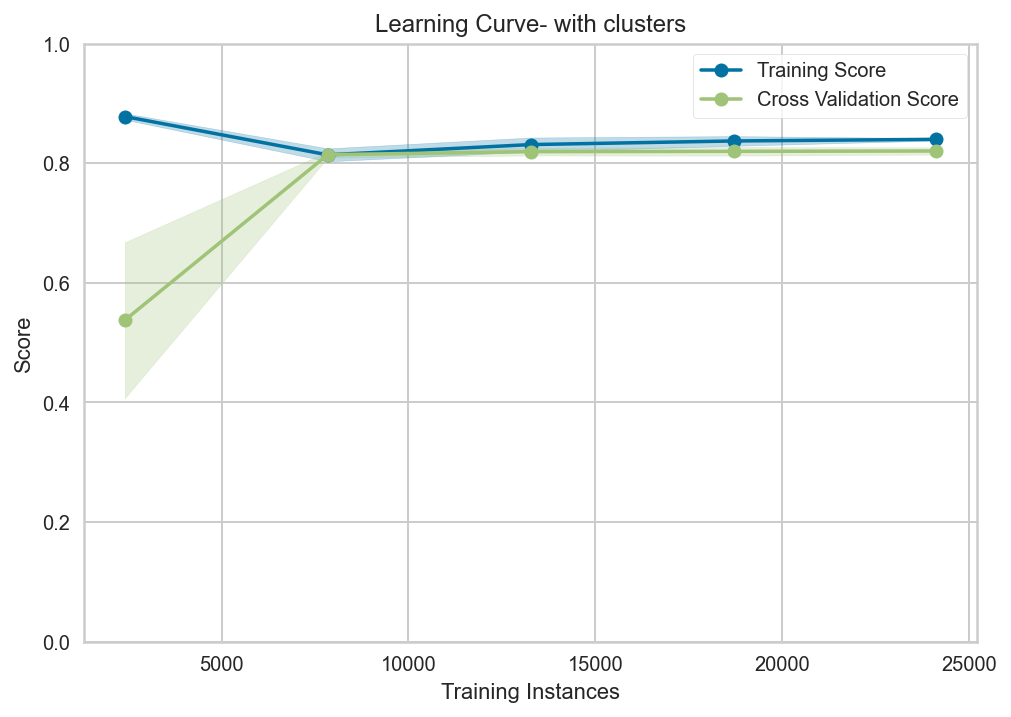

In [856]:
estimator_final = MLPClassifier(hidden_layer_sizes=(
    128, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)

model = LearningCurve(estimator_final, scoring='f1_weighted',random_state=42,title="Learning Curve- with clusters")
model.fit(X_tmp,y)
model.finalize()
model.ax.set_ylim(0,1)
model.show()

In [1101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1_weighted', train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

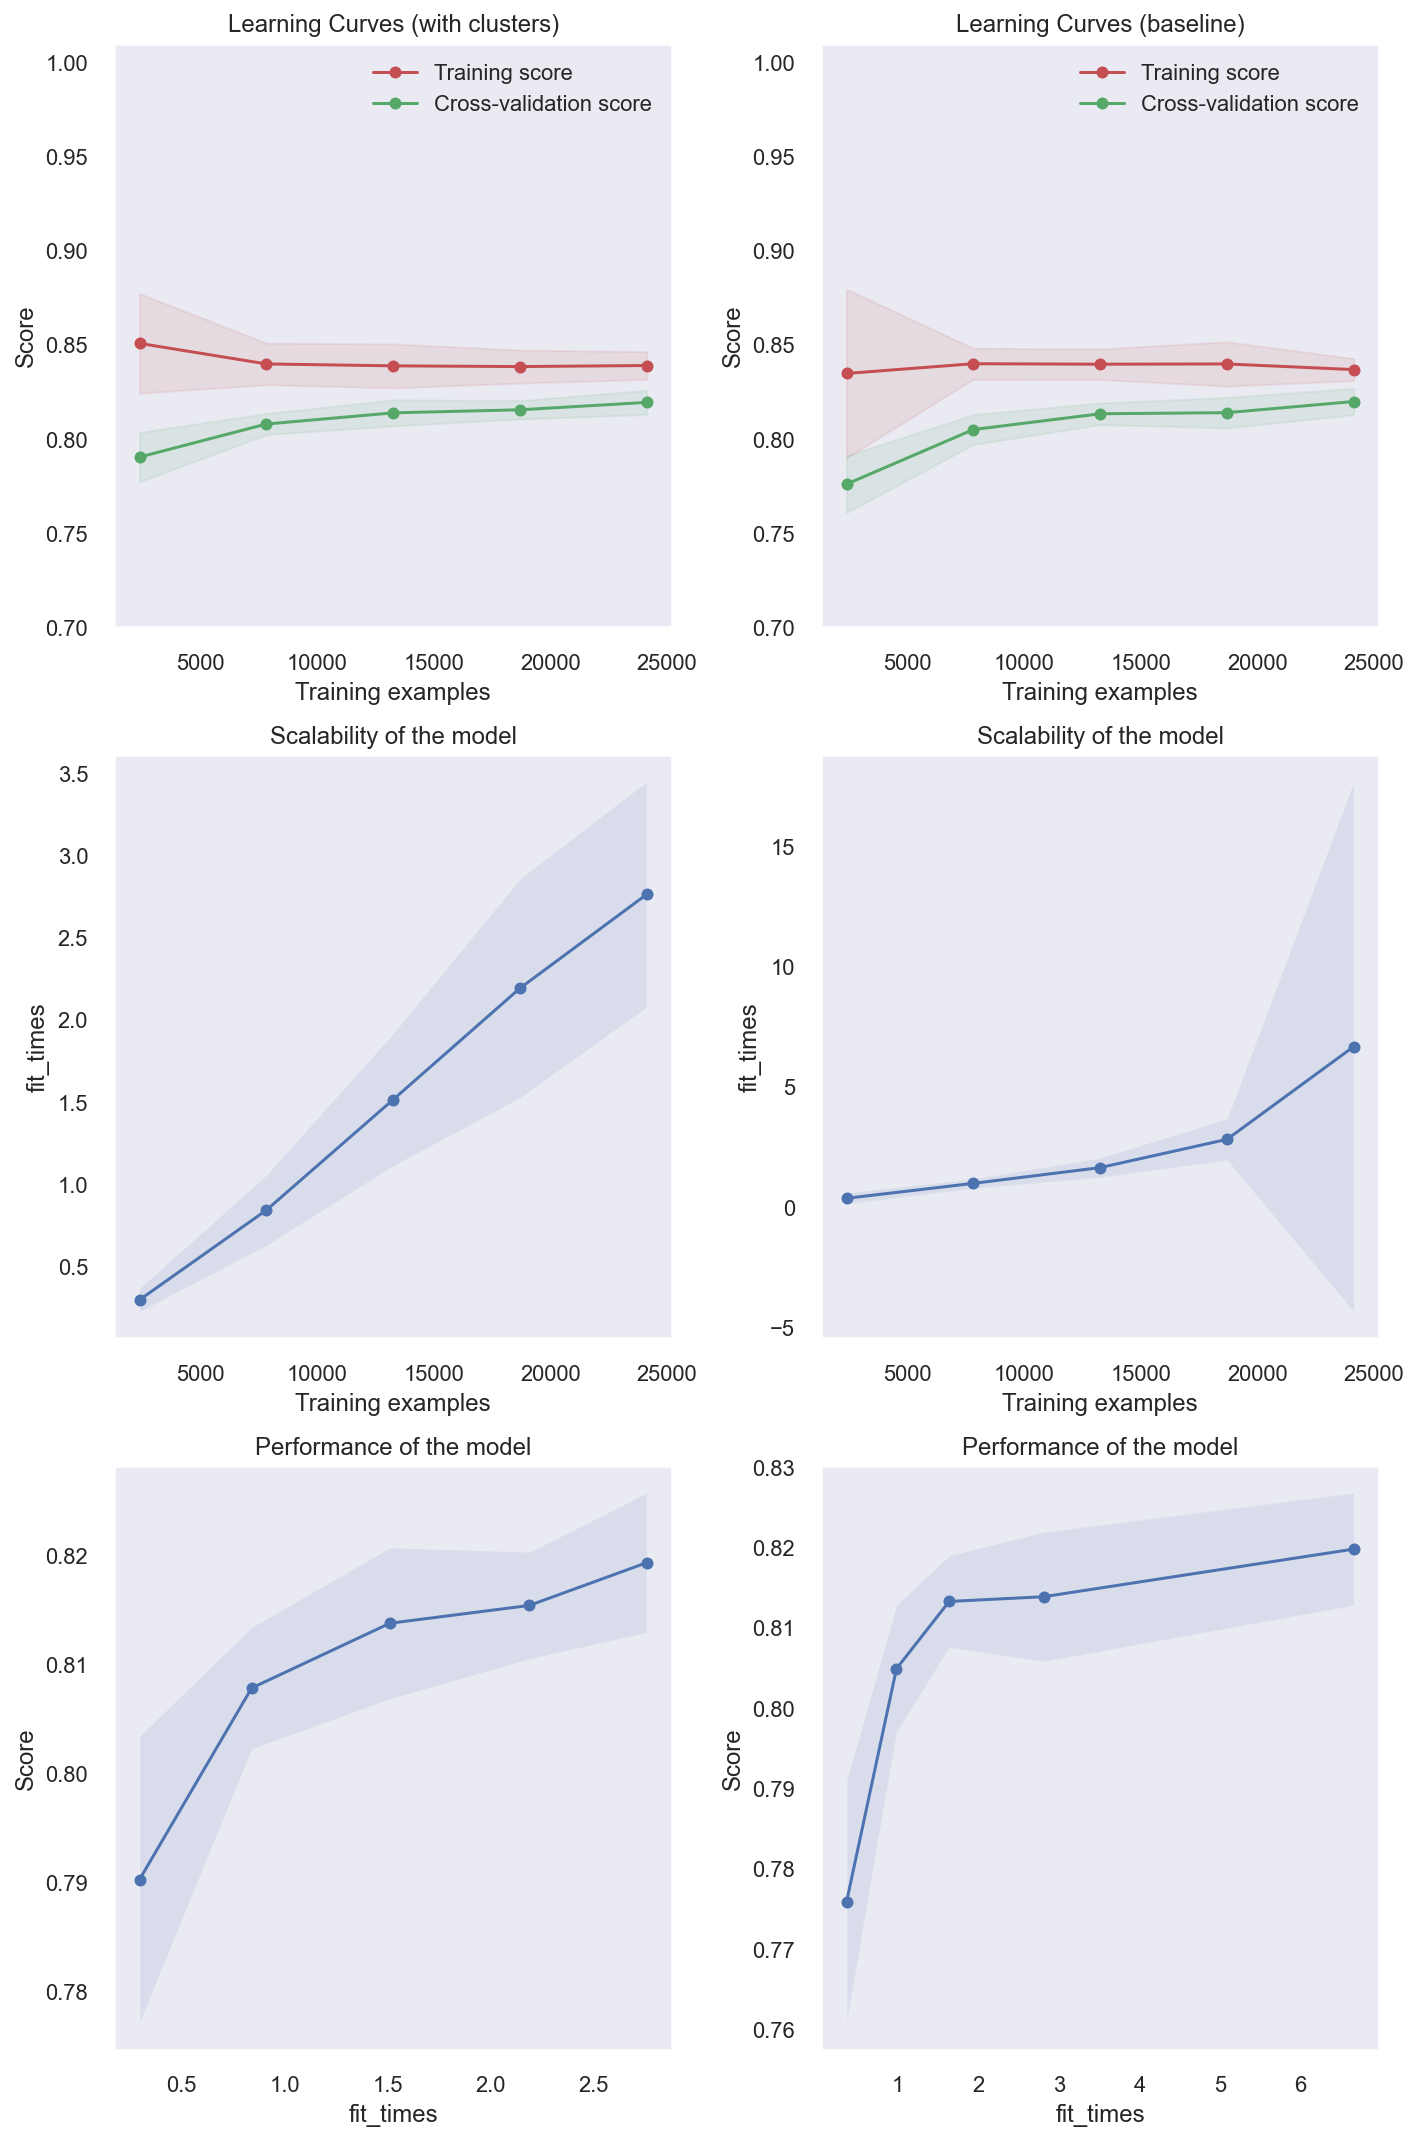

In [1102]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (with clusters)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

estimator= MLPClassifier(hidden_layer_sizes=(28, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)

plot_learning_curve(estimator, title, X_tmp, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=1)

title = "Learning Curves (baseline)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

estimator= MLPClassifier(hidden_layer_sizes=(28, 32, 16), early_stopping=True,activation='relu', learning_rate_init=0.001, solver='adam', max_iter=100, alpha=0.02, random_state= 42)

plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=1)

plt.tight_layout()
plt.show()